# Analisis a datos bancarios
Comenzamos con la importacion de las librerias para poder manejar los datos de forma correcta

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Obtencion de los datos
Procedemos a obtener los datos en un dataframe para el manejo adecuado de estos. Para su posterior limpieza y modificacion requerida

In [64]:
datos = pd.read_csv('../Datos/bank_customers.csv') # Se reciben los datos en un dataframe desde el archivo

datos.head(5)

,Customer ID,Name,Age,Gender,Address,Email,Phone Number,Account Type,Account Balance,Registration Date
0,24b6ef4a-6310-40de-b589-60d4b75f68e5,Mark Montgomery,47,Female,"52662 Olsen Keys Apt. 350\r\nNew Lauren, KS 90632",sanchezkyle@hotmail.com,190-175-3164x84539,Checking,9391.74,2024-03-19
1,a0ae8e10-73eb-4bfe-8187-5760c4a243e6,Jason King,84,Male,"13849 Romero Stream\r\nJacquelinechester, ND 3...",elewis@hotmail.com,001-985-792-0564,Checking,8395.59,2021-06-19
2,56c99350-9f0f-4cfc-8f8a-379b0c7848df,Steven Whitaker,86,Female,"3801 Brianna Ways\r\nThomasmouth, KY 06857",simmonschristopher@johnston.info,(245)011-5138,Savings,35086.30,2020-06-25
3,31398298-f9c6-40c2-8c56-9a9717c46b65,Terri Lucero,59,Male,026 Norman Villages Suite 475\r\nSouth Christo...,mbeltran@gmail.com,432.911.9239x197,Checking,93745.80,2024-05-17
4,282692f2-6693-4f4d-9beb-50239666f9fc,Jeremy Mason,25,Female,"9115 Lee Route Apt. 784\r\nSanchezmouth, DC 07910",carrie14@gmail.com,001-148-679-2508x961,Checking,3484.77,2021-05-29


# Limpieza y preparacion de los datos
Se preparan los datos cambiando tipos, verificando existencia de nulos y limpiando o modificando datos nulos de existir

In [65]:
datos.isna().sum() # verificacion de existencia de datos nulos

Customer ID          0
Name                 0
Age                  0
Gender               0
Address              0
Email                0
Phone Number         0
Account Type         0
Account Balance      0
Registration Date    0
dtype: int64

Verificamos que datos nulos no existen en los datos entregados, por lo que procedemos a verificar datos duplicados

In [66]:
datos.duplicated().sum() # Verificacion de filas duplicadas

np.int64(0)

Verificamos que no existen filas duplicadas. Por lo que continuamos con la modificacion de los tipos de datos.

In [67]:
datos.dtypes #Mostramos los tipos de datos para cada columna

Customer ID           object
Name                  object
Age                    int64
Gender                object
Address               object
Email                 object
Phone Number          object
Account Type          object
Account Balance      float64
Registration Date     object
dtype: object

Modificaremos los datos de las siguientes columnas:
- Name: object -> string
- Gender: object -> category
- Adress: object -> string
- Email: object -> string
- Phone Number: object -> string
- Account Type: object -> category
- Registration Date: object -> date

In [68]:
datos_modif = datos.copy()
datos_modif = (
    datos_modif.astype({
        'Name': 'string',
        'Gender': 'category',
        'Address': 'string',
        'Email': 'string',
        'Phone Number': 'string',
        'Account Type': 'category'
    })
)

datos_modif["Registration Date"] = pd.to_datetime(datos_modif["Registration Date"])

datos_modif.dtypes

Customer ID                  object
Name                 string[python]
Age                           int64
Gender                     category
Address              string[python]
Email                string[python]
Phone Number         string[python]
Account Type               category
Account Balance             float64
Registration Date    datetime64[ns]
dtype: object

In [69]:
datos_modif.head()

,Customer ID,Name,Age,Gender,Address,Email,Phone Number,Account Type,Account Balance,Registration Date
0,24b6ef4a-6310-40de-b589-60d4b75f68e5,Mark Montgomery,47,Female,"52662 Olsen Keys Apt. 350\r\nNew Lauren, KS 90632",sanchezkyle@hotmail.com,190-175-3164x84539,Checking,9391.74,2024-03-19
1,a0ae8e10-73eb-4bfe-8187-5760c4a243e6,Jason King,84,Male,"13849 Romero Stream\r\nJacquelinechester, ND 3...",elewis@hotmail.com,001-985-792-0564,Checking,8395.59,2021-06-19
2,56c99350-9f0f-4cfc-8f8a-379b0c7848df,Steven Whitaker,86,Female,"3801 Brianna Ways\r\nThomasmouth, KY 06857",simmonschristopher@johnston.info,(245)011-5138,Savings,35086.30,2020-06-25
3,31398298-f9c6-40c2-8c56-9a9717c46b65,Terri Lucero,59,Male,026 Norman Villages Suite 475\r\nSouth Christo...,mbeltran@gmail.com,432.911.9239x197,Checking,93745.80,2024-05-17
4,282692f2-6693-4f4d-9beb-50239666f9fc,Jeremy Mason,25,Female,"9115 Lee Route Apt. 784\r\nSanchezmouth, DC 07910",carrie14@gmail.com,001-148-679-2508x961,Checking,3484.77,2021-05-29


Ya limpios los datos podemos empezar a responder las diferentes preguntas

# ¿Cual es la distribución de Edad y Genero de los Clientes?

In [70]:
#Agrupamos por edad y Genero para contar las cantidades de coincidencias
datos_edad_genero = datos_modif.groupby(['Age', 'Gender'], observed=False).size().reset_index(name='total')

# Se crean etiquetas para rangos a verificar
valores = ['18 a 19', '20 a 29', '30 a 39', '40 a 49', '50 a 59', '60 a 69', '70 a 79', '80 a 89', '90+']
bins = [18, 20, 30, 40, 50, 60, 70, 80, 90, 100]
datos_edad_genero["edad_bins"] = pd.cut(datos_edad_genero["Age"], bins=bins, labels=valores,
                                                       right=False)


[Text(0.5, 0, 'Rangos Edad'),
 Text(0, 0.5, 'Cant. Clientes'),
 Text(0.5, 1.0, 'Distribucion Edad y Genero de Clientes')]

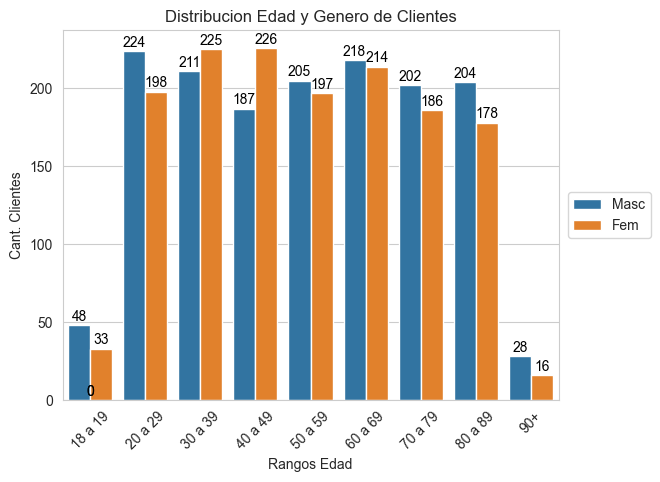

In [71]:
# Creacion del grafico
graf_distrib_edad_genero = sns.barplot(
    data=datos_edad_genero, x='edad_bins', y='total', 
    hue="Gender", hue_order=["Male", "Female"], estimator="sum",errorbar=None
)

#Mostrar los valores de cada barra en el grafico
for p in graf_distrib_edad_genero.patches:
    altura = p.get_height()
    graf_distrib_edad_genero.annotate(
        f'{int(altura)}',
        (p.get_x() + p.get_width() / 2, altura),
        ha='center', va='bottom',
        fontsize=10, color='black', xytext=(0,1),
        textcoords='offset points'
    )

# Modificar nombre de las leyendas
leyendas = graf_distrib_edad_genero.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
for texto, nombre in zip(leyendas.texts, ["Masc", "Fem"]):
    texto.set_text(nombre)

# modificar valores en el eje x
plt.xticks(rotation=45)
graf_distrib_edad_genero.set(xlabel="Rangos Edad", ylabel="Cant. Clientes", title="Distribucion Edad y Genero de Clientes")

La **mayoría de los clientes**, tanto **hombres** como **mujeres**, se concentran entre los **20 y 89 años**, con una participación **mínima** en los rangos **18–19** y **90+**.



## **Clientes femeninas**
- **Aumenta progresivamente** desde los **18 hasta los 49 años**.  
- **Leve disminución** entre **49 y 59 años**.  
- **Vuelve a incrementarse** hasta los **69 años**.  
- **Decrece** a partir de los **70 años** en adelante.



## **Clientes masculinos**
- **Crecimiento acelerado** entre los **18 y 29 años**.  
- **Caída** entre **29 y 49 años**.  
- **Nuevo aumento** entre **49 y 60 años**.  
- **Descenso progresivo** desde los **69 años** en adelante.

# ¿Que rangos de edad predominan en para cada tipo de cuenta?

In [72]:
datos_modif["Account Type"].unique().tolist() # Obtenemos los tipos de cuentas en los datos

['Checking', 'Savings']

Con esto sabemos que tipo de cuentas poseemos en el conjunto de datos, para luego poder trabajar los datos de forma correcta.

In [73]:
#Agrupamos por edad y sumamos las cuentas segun los tipos 
datos_tipoCuenta_edad = datos_modif.groupby(['Age'])\
    .agg({
        'Account Type': [
            ('ahorro', lambda x : (x == "Savings").sum()),
            ('cheque', lambda x : (x == "Checking").sum())
        ]
    }).reset_index()

# Se crean etiquetas para rangos a verificar
valores = ['18 a 19', '20 a 29', '30 a 39', '40 a 49', '50 a 59', '60 a 69', '70 a 79', '80 a 89', '90+']
bins = [18, 20, 30, 40, 50, 60, 70, 80, 90, 100]
datos_tipoCuenta_edad["rangos"] = pd.cut(datos_tipoCuenta_edad["Age"], bins=bins, labels=valores,
                                        right=False)

datos_tipoCuenta_edad = datos_tipoCuenta_edad.groupby('rangos', observed=False)\
    .agg({
        ('Account Type', 'ahorro'): 'sum',
        ('Account Type', 'cheque'): 'sum'
    },
    {'total_cuentas': 'sum'}).reset_index()

datos_tipoCuenta_edad["total_cuentas"] = (datos_tipoCuenta_edad["Account Type"]["ahorro"] 
                                          + datos_tipoCuenta_edad["Account Type"]["cheque"])

datos_tipoCuenta_edad

rangos Account Type        total_cuentas
                 ahorro cheque              
0  18 a 19           35     46            81
1  20 a 29          218    204           422
2  30 a 39          185    251           436
3  40 a 49          210    203           413
4  50 a 59          188    214           402
5  60 a 69          211    221           432
6  70 a 79          180    208           388
7  80 a 89          194    188           382
8      90+           24     20            44

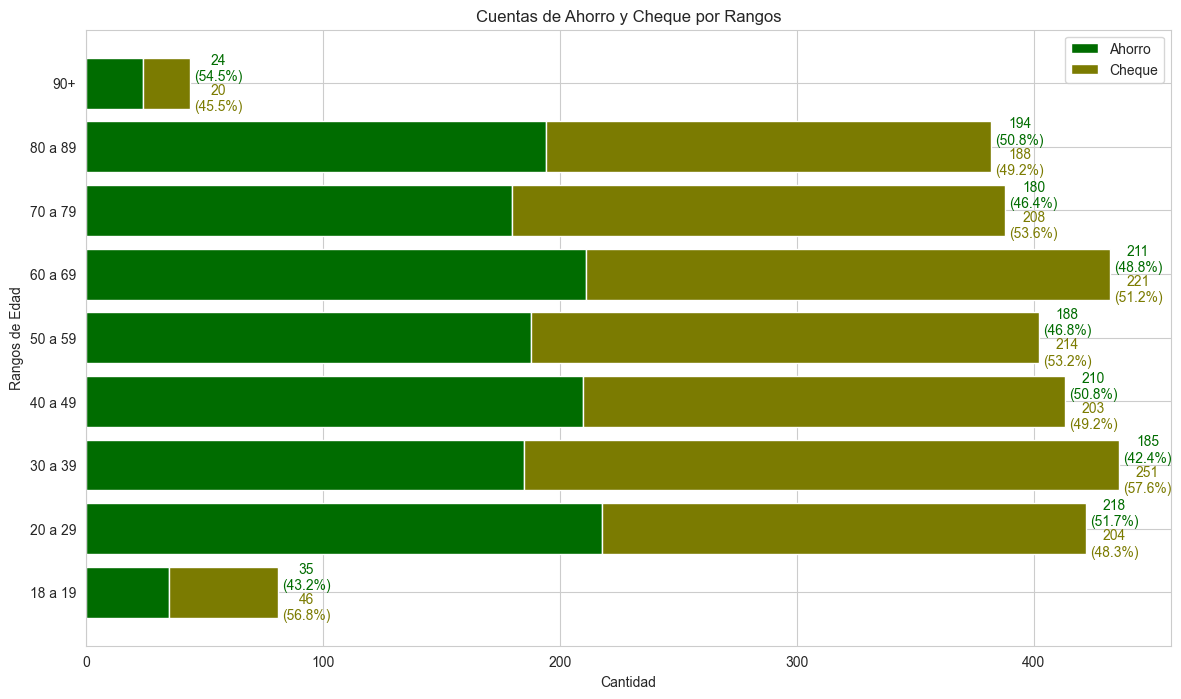

In [74]:
#Creamos el grafico de barras horizontal
# se ingresan los datos
rangos = datos_tipoCuenta_edad['rangos'].astype(str)  # eje y
ahorro = datos_tipoCuenta_edad[('Account Type', 'ahorro')] 
cheque = datos_tipoCuenta_edad[('Account Type', 'cheque')]

#Calculamos el total por rango
total = ahorro + cheque

#Calcular el porcentaje por rango
porc_ahorro = (ahorro / total) * 100
porc_cheque = (cheque / total) * 100

ahorro_vals = ahorro.values
cheque_vals = cheque.values

plt.figure(figsize=(14, 8))

# Posición en eje y
y_pos = np.arange(len(rangos))

# Se agregan las barras
plt.barh(y_pos, ahorro, label='Ahorro', color="#006C00")
plt.barh(y_pos, cheque, left=ahorro, label='Cheque', color="#7B7B01FF")  # se usa left para apilar las barras

plt.yticks(y_pos, rangos)
plt.ylabel('Rangos de Edad')
plt.xlabel('Cantidad')
plt.legend()
plt.title('Cuentas de Ahorro y Cheque por Rangos')

#Se agregan etiquetas de cantidad y porcentaje para ahorro
for i in range(len(rangos)):
    plt.text( ahorro[i]+cheque[i]+12, y_pos[i], f"{ahorro_vals[i]}\n({porc_ahorro.iloc[i]:.1f}%)", va='bottom', ha='center', 
                    color='#006C00')

#Etiquetas de barras cheque
for i in range(len(rangos)):
    plt.text(ahorro[i]+cheque[i]+12, y_pos[i], f"{cheque_vals[i]}\n({porc_cheque.iloc[i]:.1f}%)",va='top', ha='center', 
                    color="#7B7B01FF" )


plt.show()


In [75]:
cant_porcent_datos_tipoCuenta = datos_modif.groupby("Account Type", observed=False).size().reset_index(name='total')

cant_porcent_datos_tipoCuenta["porc_total"] = (cant_porcent_datos_tipoCuenta["total"]/cant_porcent_datos_tipoCuenta["total"].sum())*100

cant_porcent_datos_tipoCuenta


,Account Type,total,porc_total
0,Checking,1555,51.833333
1,Savings,1445,48.166667


### **1. Cuenta tipo Cheque** *(predomina en 6 de 9 rangos)*
| Rango etario | Porcentaje |
|--------------|------------|
| 90+          | 54.5%      |
| 70 a 79      | 53.6%      |
| 60 a 69      | 51.2%      |
| 50 a 59      | 53.2%      |
| 30 a 39      | **57.6%** *(máximo)* |
| 18 a 19      | 56.8%      |

> **Total cuentas Cheque:** 1.555 → **54.8%** del universo



### **2. Cuenta tipo Ahorro** *(predomina en 3 de 9 rangos)*
| Rango etario | Porcentaje |
|--------------|------------|
| 80 a 89      | 50.8%      |
| 40 a 49      | 50.8%      |
| 20 a 29      | **51.7%** *(máximo)* |

> **Total cuentas Ahorro:** 1.445 → **48.2%** del universo



## **Resumen breve**
- **Cuenta Cheque** predomina en:  
  **18-19, 30-39, 50-59, 60-69, 70-79, 90+**
- **Cuenta Ahorro** predomina en:  
  **20-29, 40-49, 80-89**

> **Conclusión general:** El tipo **Cheque** es el más frecuente en la mayoría de los grupos etarios y en la totalidad de los datos

# ¿Cuál es la distribución geográfica (basada en dirección) de los clientes?
Para poder verificar esto, obtendremos la informacion y los limpiaremos el dato de dirección que poseen los datos

In [76]:
datos_modif.columns

Index(['Customer ID', 'Name', 'Age', 'Gender', 'Address', 'Email',
       'Phone Number', 'Account Type', 'Account Balance', 'Registration Date'],
      dtype='object')

In [77]:
# Obtener datos a manejar
distrib_geograf = datos_modif[["Customer ID", "Address"]].copy()
distrib_geograf_noModif = datos_modif[["Customer ID", "Address"]].copy()

# Separaremos la dirección de su estado
distrib_geograf["State"] = distrib_geograf["Address"].str.split(',').str[1].str.split(' ').str[1]
distrib_geograf_noModif["State"] = distrib_geograf_noModif["Address"].str.split(',').str[1].str.split(' ').str[1]

# # Convertir State a string
distrib_geograf = distrib_geograf.astype({'State': 'string'})

#Condiciones de modificacion de estados militares
condicionAA = distrib_geograf["Address"].str.contains(' AA ')
condicionAP = distrib_geograf["Address"].str.contains(' AP ')
condicionAE = distrib_geograf["Address"].str.contains(' AE ')

# modificaciones a estados militares
distrib_geograf.loc[condicionAA, 'State'] = 'AA'
distrib_geograf.loc[condicionAP, 'State'] = 'AP'
distrib_geograf.loc[condicionAE, 'State'] = 'AE'

# Creacion de la tabla para el grafico de distribucion geografica
distrib_geograf = distrib_geograf.groupby('State').agg(clientes=('Customer ID', 'count'))
distrib_geograf.head()

,clientes
State,
AA,92
AE,93
AK,50
AL,54
AP,103


Ya obtenida la tabla para la distribucion geografica, procedemos a crear el grafico

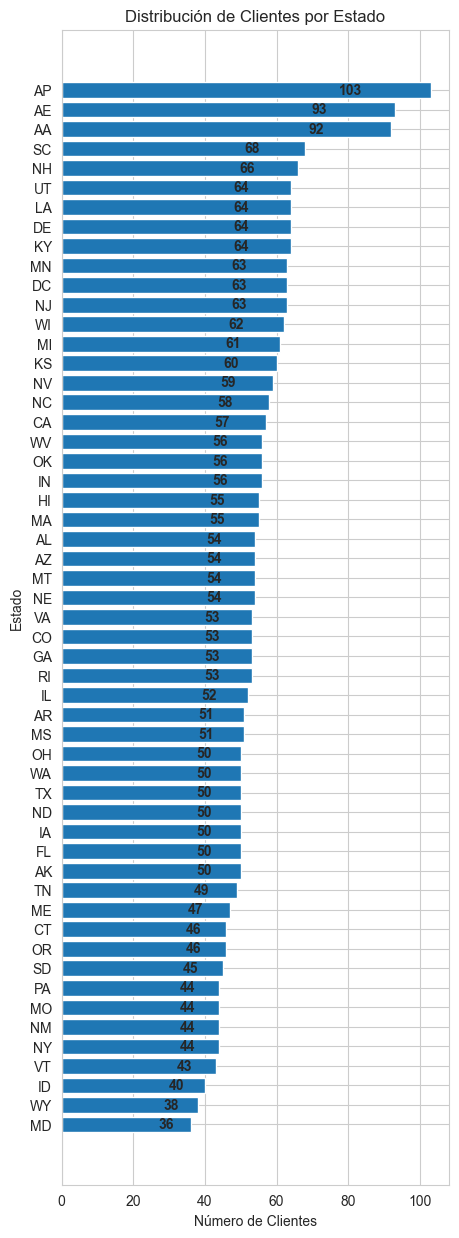

In [78]:
# Se ordena de mayor a menor la tabla
distrib_geograf = distrib_geograf.sort_values("clientes",ascending=True)


plt.figure(figsize=(5, 15))  # Tamaño ajustable
grafico_dist_geograf = plt.barh(distrib_geograf.index, distrib_geograf['clientes'])
plt.xlabel('Número de Clientes')
plt.ylabel('Estado')
plt.title('Distribución de Clientes por Estado')

# Se muestra la etiqueta de graficos
for i, barra in enumerate(grafico_dist_geograf):
    ancho = barra.get_width() # Se obtiene el ancho de las barras
    plt.text( ancho*0.75, barra.get_y() + barra.get_height()/2, # posicion ligeramente a la derecha
                    f'{int(ancho)}', # Valor entero de la etiqueta
                    ha='left',  va='center', fontsize=10, fontweight='bold') # Alienacion y estilo

plt.show()  # Muestra el gráfico

## Nota Importante
Se identificaron **3 códigos no correspondientes a estados civiles de EE.UU.**:
- **AP** (Armed Forces Pacific)
- **AE** (Armed Forces Europe, Middle East, Africa, and Canada)
- **AA** (Armed Forces Americas)

Estos representan **direcciones militares postales en el extranjero**.



## Top 5 Estados con Mayor Cantidad de Clientes

### **Incluyendo direcciones militares**
| Posición | Código | Estado / Zona Militar              | Clientes |
|----------|--------|------------------------------------|----------|
| 1        | AP     | Armed Forces Pacific               | **103**  |
| 2        | AE     | Armed Forces Europe, etc.          | **96**   |
| 3        | AA     | Armed Forces Americas              | **95**   |
| 4        | SC     | Carolina del Sur                   | 68       |
| 5        | NH     | Nuevo Hampshire                    | 66       |

### **Excluyendo direcciones militares**
| Posición | Código | Estado                  | Clientes |
|----------|--------|-------------------------|----------|
| 1        | SC     | Carolina del Sur        | **68**   |
| 2        | NH     | Nuevo Hampshire         | **66**   |
| 3        | UT     | Utah                    | 64       |
| 4        | LA     | Luisiana                | 64       |
| 5        | DE     | Delaware                | 64       |



## Estados con Menos Clientes
Los estados con la **menor cantidad de clientes** son:  
**MD** (Maryland), **WY** (Wyoming), **ID** (Idaho), **VT** (Vermont)



## Conclusión
> La distribución geográfica revela una **fuerte concentración de clientes en direcciones militares postales (AP, AE, AA)**, superando ampliamente a los estados civiles.  
> Esto indica una **alta disposición de clientes vinculados a bases militares en el extranjero**, en contraste con una menor presencia en estados civiles tradicionales de EE.UU.

# ¿Cuál es el rango y promedio del saldo de cuenta por tipo de cuenta?

Se procede a obtener los datos necesarios para el analisis de esta pregunta.

In [79]:
# Obtenemos la copia para atacar esta pregunta
rangoPromSaldo_tipoCuenta = datos_modif.copy().groupby("Account Type",observed=False)\
        .agg(
            saldo_min = ("Account Balance", "min"),
            saldo_max = ("Account Balance", "max"),
            saldo_prom = ("Account Balance", "mean")
        ).reset_index()

rangoPromSaldo_tipoCuenta

,Account Type,saldo_min,saldo_max,saldo_prom
0,Checking,225.96,99973.61,51192.643563
1,Savings,100.77,99965.69,50377.879945


Obtenidos los datos pasamos a usarlos para el grafico

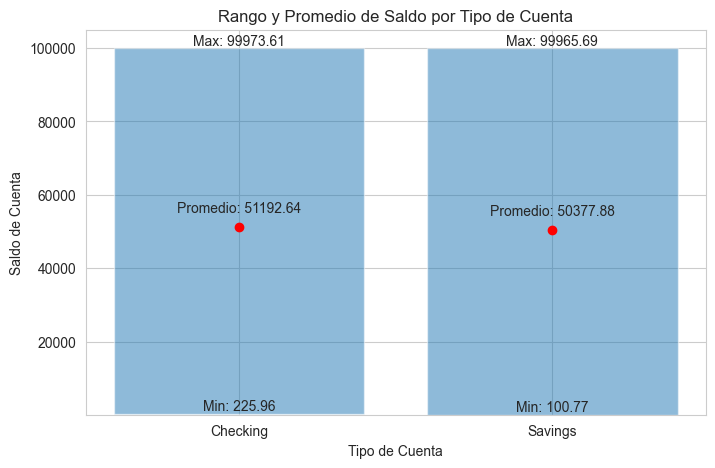

In [80]:
# Obtenemos el rango que poseen los datos
x = np.arange(len(rangoPromSaldo_tipoCuenta))

fig, ax = plt.subplots(figsize=(8,5)) # Posiciones en el eje x

# barras para el rango min a max 
barras = ax.bar(x, rangoPromSaldo_tipoCuenta["saldo_max"] - rangoPromSaldo_tipoCuenta["saldo_min"], 
                bottom=rangoPromSaldo_tipoCuenta["saldo_min"], alpha=0.5 )

# Agregamos puntos para el promedio 
ax.scatter(x, rangoPromSaldo_tipoCuenta["saldo_prom"], color='red', label='Promedio', zorder=5)

# Etiquetas y leyendas
ax.set_xticks(x) # Cantidad de barras
ax.set_xticklabels(rangoPromSaldo_tipoCuenta["Account Type"]) # Agregar etiqueta de tipo de cuenta
# Etiquetas Grafico
ax.set_ylabel('Saldo de Cuenta')
ax.set_xlabel('Tipo de Cuenta')
ax.set_title('Rango y Promedio de Saldo por Tipo de Cuenta')

# Agregar etiquetas para min, max y promedio por barra
for i in x:
    ax.text(i, rangoPromSaldo_tipoCuenta["saldo_min"][i]+4000, 
        f'Min: {rangoPromSaldo_tipoCuenta['saldo_min'][i]:.2f}', ha='center', va='top', fontsize=10)
    ax.text(i, rangoPromSaldo_tipoCuenta["saldo_max"][i], 
        f'Max: {rangoPromSaldo_tipoCuenta['saldo_max'][i]:.2f}', ha='center', va='bottom', fontsize=10)
    ax.text(i, rangoPromSaldo_tipoCuenta["saldo_prom"][i]+5000,
        f'Promedio: {rangoPromSaldo_tipoCuenta["saldo_prom"][i]:.2f}', ha='center', va='center', fontsize=10 )



#### Promedios del saldo por tipo de cuenta:
| Tipo de Cuenta | Promedio (Saldo) |
|----------------|------------------|
| **Checking**   | 5,119.64        |
| **Savings**    | 5,037.88        |

**Conclusión sobre promedios**:  
Como se ve en la tabla, el promedio es muy cercano entre los tipos de cuentas (diferencia de solo 81.76), lo que indica un **equilibrio** en el uso y saldo promedio de las cuentas *Checking* y *Savings*.

#### Rangos del saldo por tipo de cuenta:
| Tipo de Cuenta | Mínimo (Saldo) | Máximo (Saldo) | Rango (Máx - Mín) |
|----------------|----------------|----------------|-------------------|
| **Checking**   | 225.96        | 99,973.61     | 99,747.65        |
| **Savings**    | 100.77        | 99,965.69     | 99,864.92        |

**Conclusión sobre rangos**:
- Los promedios son muy similares, lo que sugiere que ambos tipos de cuentas presentan niveles comparables de **volatilidad** en términos generales.
- Los valores máximos son prácticamente idénticos (diferencia de solo 7.92), lo que confirma la presencia de **clientes de alto valor** en ambas categorías.
- La diferencia en los mínimos es significativa (**100.77** en *Savings* vs. **225.96** en *Checking*), indicando que las cuentas *Savings* permiten saldos iniciales más bajos, mientras que las *Checking* tienen un umbral mínimo más elevado.

> **En resumen**: los tipos de cuenta muestran un comportamiento equilibrado en promedio y en extremos superiores, pero con variaciones notables en los saldos mínimos.

# ¿Existe alguna relación entre edad, tipo de cuenta y saldo promedio?
Procederemos a verificar si existe una relacion entre edad y saldo promedio por tipo de cuenta.

In [81]:
# Obtenemos una copia para trabajar los datos
datos_dispersion = datos_modif.copy()

# Obtenemos el promedio de saldo por edad
promedioSaldo_edad = datos_dispersion.groupby(["Age", "Account Type"],observed=False).agg(
    promedio_saldo = ("Account Balance", "mean")
).reset_index()

# Ponemos como maximo 2 decimales a los promedios
promedioSaldo_edad["promedio_saldo"] = promedioSaldo_edad["promedio_saldo"].round(2)

correlacion = promedioSaldo_edad[["Age", "promedio_saldo"]].corr(method="pearson")

correlacion

,Age,promedio_saldo
Age,1.00000,-0.08349
promedio_saldo,-0.08349,1.00000


Al  hacer un analisis basico de correlacion entre la edad y el promedio de saldo, nos arroja que esta es ligeramente debil. Lo que significa que el saldo promedio debe disminuir segun la edad avanza pero de forma muy leve.

<Figure size 1200x500 with 0 Axes>

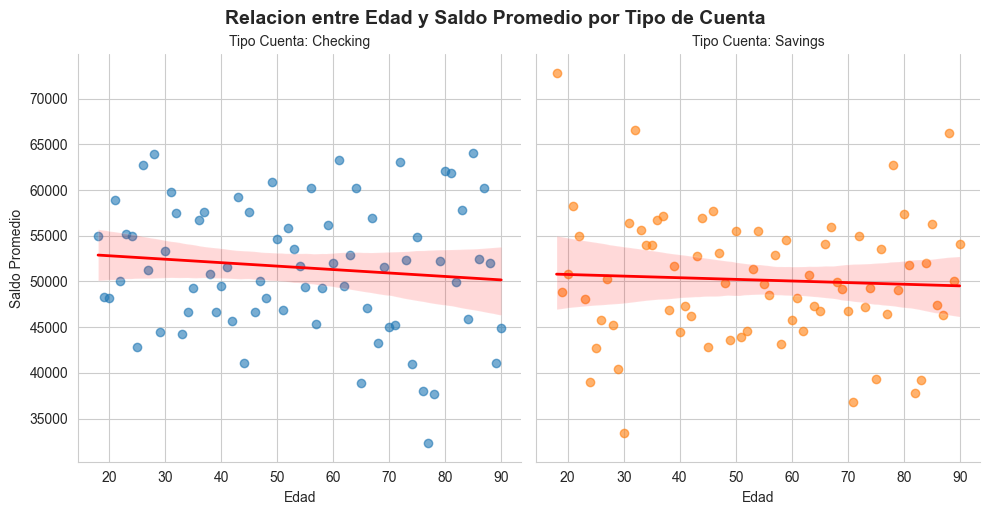

In [82]:
# Creamos el grafico de dispersion.
# Configuracion para mejor legibilidad
sns.set_style("whitegrid")
plt.figure( figsize=(12,5) ) # Tamaño de de espacios

#Graficos
grafs = sns.lmplot(
    data=promedioSaldo_edad, x="Age", y="promedio_saldo", hue="Account Type",
    col="Account Type", ci=95, # Separacion por tipo cuenta,  intervalo de confianza
    scatter_kws={'alpha':0.6}, # transparencia para siperposiciones
    line_kws={'color': 'red', 'lw': 2}, # Grosor de linea 
    facet_kws={'sharey': True}
)

# Etiquetas
grafs.set_axis_labels("Edad", "Saldo Promedio")
grafs.set_titles("Tipo Cuenta: {col_name}") # formato titulos graficos
grafs.fig.suptitle("Relacion entre Edad y Saldo Promedio por Tipo de Cuenta", y=1.02, fontsize=14, 
                   fontweight='bold')



plt.show()

## Relación entre Edad, Tipo de Cuenta y Saldo Promedio

**Sí, existe una relación** entre la **edad**, el **tipo de cuenta** y el **saldo promedio**, con las siguientes características clave:



## Relación General
- **Tendencia negativa**: En ambos tipos de cuenta (Checking y Savings), el **saldo promedio disminuye** a medida que **aumenta la edad** del cliente.



## Diferencias por Tipo de Cuenta

| Tipo de Cuenta | Fuerza de la Relación | Interpretación |
|----------------|-----------------------|----------------|
| **Checking**   | **Negativa moderada** | La pérdida de saldo con la edad es **considerable**. |
| **Savings**    | **Nula o débil**      | Aunque hay disminución, **no es significativa** → los saldos se mantienen más estables. |



## Efectos Clave

- **Tipo de cuenta**: Afecta de forma **moderada** al comportamiento del saldo con la edad.
- **Edad (global)**: Provoca una **ligera disminución** del saldo promedio (confirmado por la correlación general).



## Conclusión
> **El tipo de cuenta modula la intensidad de la relación entre edad y saldo.**  
> - En **Checking**, la edad impacta **más fuertemente**.  
> - En **Savings**, el efecto es **mínimo**.  
> **Globalmente**, predomina una **tendencia a la baja suave** con el aumento de la edad.

# ¿Cómo varía el saldo promedio según el género?

In [83]:
# Obtenemos los datos
saldoProm_genero = datos_modif.copy().groupby("Gender",observed=False)\
    .agg(saldo_promedio = ("Account Balance","mean"))

saldoProm_genero["saldo_promedio"] = saldoProm_genero["saldo_promedio"].round(2) # maximo 2 decimales

# Modificacion de Generos

saldoProm_genero.loc[saldoProm_genero.index.str.contains("Male"), 'Sexo'] = 'Masculino'
saldoProm_genero.loc[saldoProm_genero.index.str.contains("Female"), 'Sexo'] = 'Femenino'


Text(0.5, 0.98, 'Saldo Promedio por Genero')

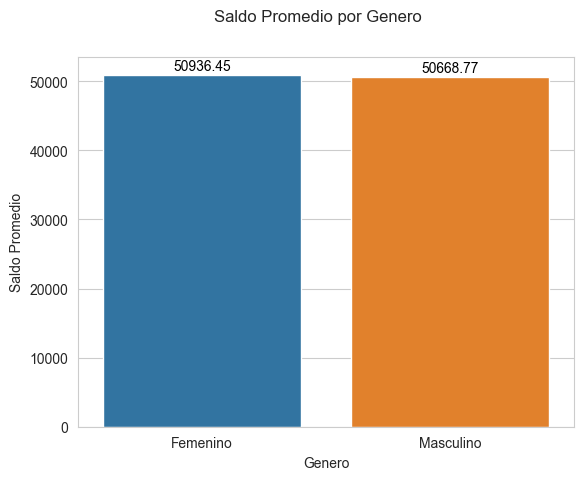

In [84]:
# Creacion del grafico
grafbar_saldoProm_genero = sns.barplot(
    data=saldoProm_genero, x='Sexo', y='saldo_promedio', 
    hue="Sexo",errorbar=None
)

#Mostrar los valores de cada barra en el grafico
for p in grafbar_saldoProm_genero.patches:
    altura = p.get_height()
    grafbar_saldoProm_genero.annotate(
        f'{float(altura)}',
        (p.get_x() + p.get_width() / 2, altura),
        ha='center', va='bottom',
        fontsize=10, color='black', xytext=(0,1),
        textcoords='offset points'
    )

plt.xlabel('Genero')
plt.ylabel('Saldo Promedio')
plt.suptitle('Saldo Promedio por Genero')

## Variación del Saldo Promedio según el Género

El saldo promedio varía según el género de la siguiente manera:

- **Promedio femenino**: 50.936,45  
- **Promedio masculino**: 50.668,77  

La **diferencia** entre ambos promedios es de **267,68** (aproximado a 266,68 en el análisis), lo que representa una variación **no significativa**.  

**Conclusión**: El género femenino presenta el **saldo promedio más alto**, aunque la diferencia con el masculino es mínima y no indica una disparidad relevante.

# ¿Cuándo se registran más clientes, en qué fechas o meses?
Procederemos a verificar en que momento se registran mas clientes

In [85]:
registros_mes = datos_modif.copy()

In [86]:
# Agrupar los datos por años_meses
registros_mes["year_month"] = registros_mes["Registration Date"].dt.to_period('M')
registros_meses_años = registros_mes.groupby("year_month").agg(total=("Customer ID", "count")).reset_index()

# obtener lista de años
años = registros_mes["Registration Date"].dt.year.unique()

# Se ordenan los años
años = sorted(años)

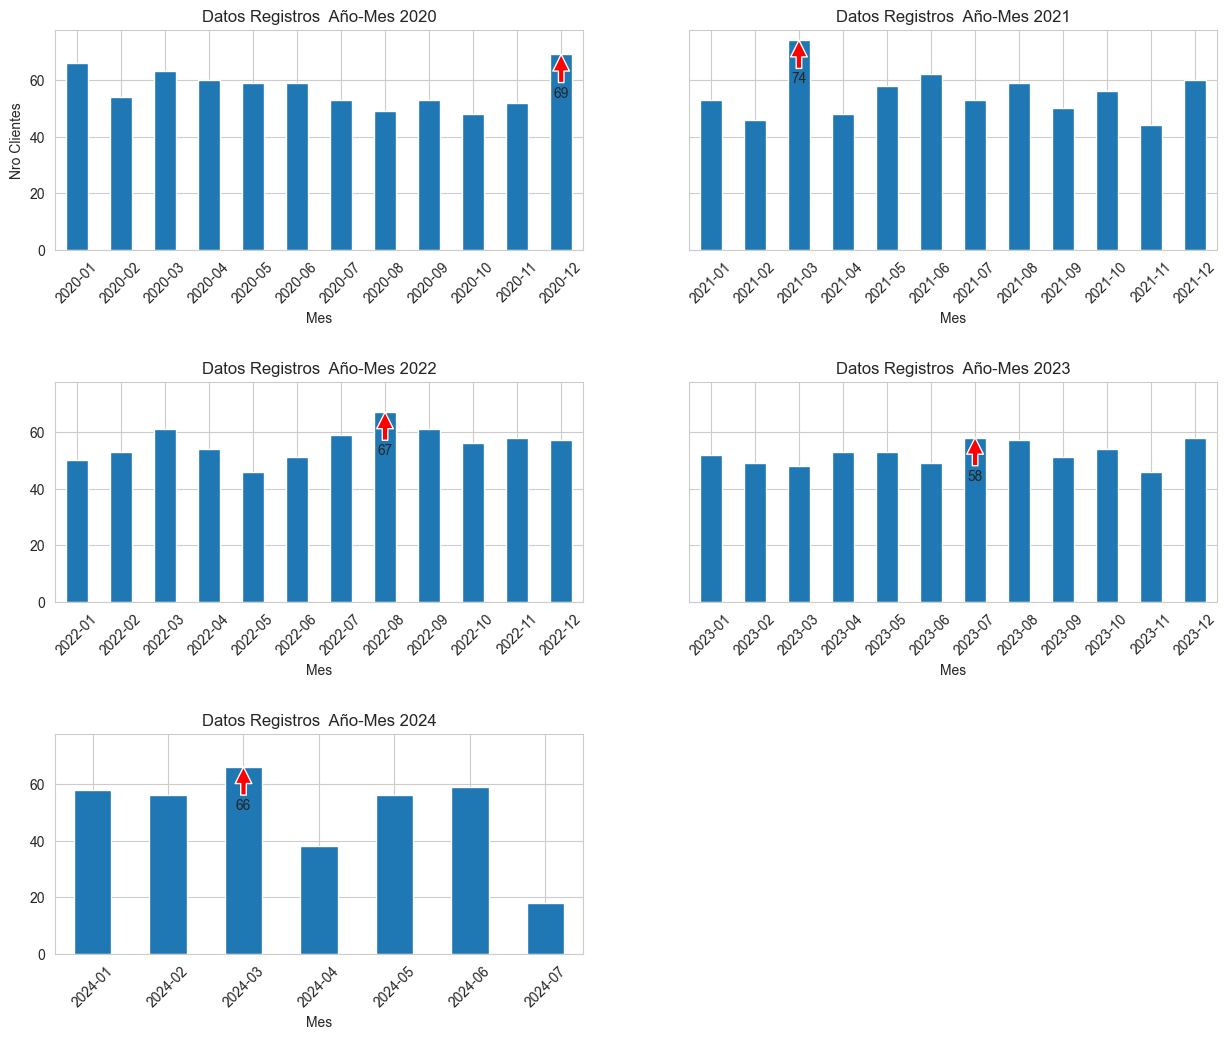

In [87]:
# Confeccion de graficos multiples
fig, axes = plt.subplots( 3, 2, figsize=(15,12), sharey=True)

# Se agrega espacio entre filas de graficos para mejor lectura
fig.subplots_adjust(hspace=0.6)

axes = axes.flatten() # Se aplana la figura del grafico

# Se recorren los años
for i, año in enumerate(años):
    # Se filtran por año y se agrupa por el mes
    datos_años = registros_mes[ registros_mes['Registration Date'].dt.year == año ].groupby("year_month")\
        .agg(total=("Customer ID", "count")).reset_index()
    
    max_año = datos_años["total"].max()
    
    # Se crean los graficos a mostrar
    datos_años.plot(kind="bar", ax=axes[i], legend=False)
    axes[i].set_title(f'Datos Registros  Año-Mes {año}')
    axes[i].set_xlabel(f'Mes')

    if i == 0:
        axes[i].set_ylabel('Nro Clientes')
    
    # Poner los valores de year_month en el eje x
    axes[i].set_xticks(range(len(datos_años)))
    axes[i].set_xticklabels(datos_años['year_month'], rotation=45)

    # Obtener índice del máximo para saber dónde poner anotación
    idx_max = datos_años['total'].idxmax()
    # Anotar el máximo en el gráfico
    axes[i].annotate(f'{max_año}', xy=(idx_max, max_año), xytext=(idx_max, max_año - 15),
        arrowprops=dict(facecolor='red', shrink=1), ha='center')

# Se elimina el ultimo grafico, que esta sin datos 
if len(años) < len(axes):
    for j in range(len(años), len(axes)):
        fig.delaxes(axes[j])

# Se muestra la informacion
plt.show()

Los clientes se registran en mayor cantidad durante **meses específicos de invierno (para EE.UU.) o en la mitad del año**, con una clara concentración en periodos estacionales. Según el análisis de datos históricos (2020–2024*), los **meses pico de registro** son los siguientes:

| Año   | Mes pico          | Clientes |
|-------|-------------------|----------|
| 2020  | Octubre           | 69       |
| 2021  | Enero             | **74**   |
| 2022  | Julio             | 67       |
| 2023  | Agosto            | 58       |
| 2024* | Febrero           | 66       |

> **Máximo histórico**: **74 clientes en enero de 2021**  
> **Mínimo de los picos**: **58 clientes en agosto de 2023**  
> **Promedio de máximos anuales**: **66.8 clientes**

### Tendencia clara:
- **Invierno (EE.UU.)**: **Enero y febrero** destacan (74 en ene/2021 y 66 en feb/2024).
- **Mitad de año / finales**: **Julio, agosto y octubre** también son meses de alta actividad (67, 58 y 69 respectivamente).

### Conclusión:
> **Los mayores registros de clientes ocurren principalmente en:**
> - **Enero – Febrero** (pico de invierno)
> - **Julio – Agosto – Octubre** (mitad y fin de año)

**Promedio esperado en meses pico: ~67 clientes**.  
Los años **2020, 2021 y 2022** superaron o cumplieron este promedio; **2023 y 2024** (incompleto) quedaron por debajo.

# ¿Hay patrones de registro según temporada o año?

In [88]:
# obtenemos los datos
gLineal_regMesesAños = registros_meses_años.copy()

# Creamos funcion que agregue campo temporada
def agregar_temporada( mes ):
    if mes in [12,1,2]:
        return 'Invierno'
    elif mes in [3,4,5]:
        return 'Primavera'
    elif mes in [6,7,8]:
        return 'Verano'
    elif mes in [9,10,11]:
        return 'Otoño'
    else:
        return 'Desconocido'

# Creamos un campo temporal que nos ayude a moficiar el dataframe
gLineal_regMesesAños["mes"] = gLineal_regMesesAños["year_month"].astype(str).str.split('-').str[1].astype(int)

gLineal_regMesesAños["temporada"] = gLineal_regMesesAños['mes'].apply(agregar_temporada) # Aplicamos la funcion

gLineal_regMesesAños = gLineal_regMesesAños.drop(columns="mes") # Borramos el campo temporal

gLineal_regMesesAños["año"] = gLineal_regMesesAños["year_month"].astype(str).str.split('-').str[0].astype(int) # Agrego año al dataframe

gLineal_regMesesAños


,year_month,total,temporada,año
0,2020-01,66,Invierno,2020
1,2020-02,54,Invierno,2020
2,2020-03,63,Primavera,2020
3,2020-04,60,Primavera,2020
4,2020-05,59,Primavera,2020
5,2020-06,59,Verano,2020
6,2020-07,53,Verano,2020
7,2020-08,49,Verano,2020
8,2020-09,53,Otoño,2020
9,2020-10,48,Otoño,2020


Ya preparada la informacion, procedemos a crear el grafico lineal segun temporada

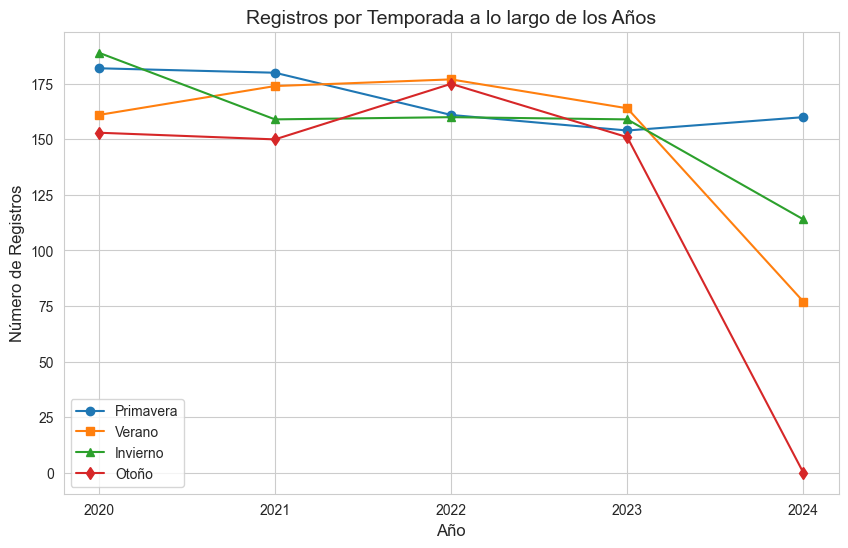

In [89]:
# obtenemos los años sin repetir
años = gLineal_regMesesAños["year_month"].astype(str).str.split('-').str[0].unique()

# Obtenemos datos por temparada y año
primavera = gLineal_regMesesAños[gLineal_regMesesAños["temporada"] == 'Primavera'].groupby("año").agg( total_tempAño = ("total", "sum") )
verano = gLineal_regMesesAños[gLineal_regMesesAños["temporada"] == 'Verano'].groupby("año").agg( total_tempAño = ("total", "sum") )
invierno = gLineal_regMesesAños[gLineal_regMesesAños["temporada"] == 'Invierno'].groupby("año").agg( total_tempAño = ("total", "sum") )
otoño = gLineal_regMesesAños[gLineal_regMesesAños["temporada"] == 'Otoño'].groupby("año").agg( total_tempAño = ("total", "sum") ).reset_index()

# Agreamos otoño 2024 en 0 por falta de datos
nueva_fila_df = pd.DataFrame({'año': [2024], 'total_tempAño': [0]})
otoño = pd.concat( [otoño, nueva_fila_df], ignore_index=True )


# Creamos el grafico
plt.figure(figsize=(10, 6))
plt.plot(años, primavera, label='Primavera', marker="o")
plt.plot(años, verano, label='Verano', marker="s")
plt.plot(años, invierno, label='Invierno', marker="^")
plt.plot(años, otoño['total_tempAño'], label='Otoño', marker="d")

# Personalizar el gráfico
plt.title('Registros por Temporada a lo largo de los Años', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de Registros', fontsize=12)
plt.legend()  # Mostrar leyenda
plt.grid(True)  # Agregar cuadrícula
plt.xticks(años)  # Asegurar que los años aparezcan en el eje X

# Mostrar el gráfico
plt.show()

## Se observan **patrones claros** en los registros según **año** y **temporada**:

- **Estabilidad 2020-2023**:  
  Los datos se mantienen en un rango consistente de **150 a 175 registros por temporada** en cada año, lo que indica un **patrón de regularidad anual** sin variaciones significativas entre estaciones.

- **Declive en 2024**:  
  Se produce una **caída generalizada** en la mayoría de las temporadas, con un **mínimo de 75 registros** y un **máximo aproximado de 160**, rompiendo el patrón de estabilidad previa.

- **Ausencia de datos en otoño 2024**:  
  El valor de **0 registros** no refleja un patrón real, sino una **falta de información** para esa temporada, lo que debe considerarse al interpretar el gráfico.

### En resumen:
Existe un **patrón de estabilidad alta hasta 2023**, seguido de un **descenso marcado en 2024** (excluyendo el otoño, sin datos).

# ¿Cuál es el crecimiento en número de clientes a lo largo del tiempo?

In [90]:
# Obtenemos los datos
crecimientoEnTiempo = datos_modif[["Customer ID", "Registration Date"]].copy()

# Se agrega dato de año-trimestre
crecimientoEnTiempo["Trimestre"] = crecimientoEnTiempo["Registration Date"].dt.year.astype(str) + '-Q' \
    + crecimientoEnTiempo["Registration Date"].dt.quarter.astype(str)

# Agrupamos por trimestre y calculamos la cantidad de clientes
crecimientoEnTiempo = crecimientoEnTiempo.groupby("Trimestre").agg(total_clientes = ("Customer ID", "count")).reset_index()

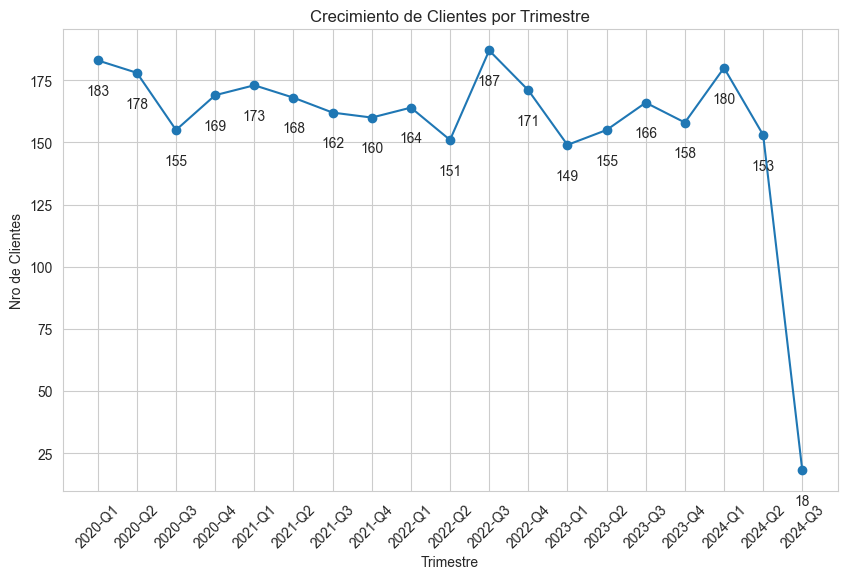

In [91]:
# Creamos el grafico
plt.figure(figsize=(10,6))
plt.plot(crecimientoEnTiempo["Trimestre"], crecimientoEnTiempo["total_clientes"], marker="o" )
plt.title("Crecimiento de Clientes por Trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Nro de Clientes")
plt.grid(True)
plt.xticks(rotation=45)

# Agregamos etiquetas a cada punto
for i, txt in enumerate(crecimientoEnTiempo["total_clientes"]):
    plt.annotate(txt, ( crecimientoEnTiempo["Trimestre"][i], crecimientoEnTiempo["total_clientes"][i] ),
                       textcoords="offset points", xytext=(0,-25), ha="center")

plt.show()

## Crecimiento en el número de clientes (2020-2024)

El crecimiento en el número de clientes **no muestra un patrón claro de tendencia sostenida**, sino **fluctuaciones trimestrales** con probables influencias externas (como la pandemia de COVID-19 en 2020-2021).

## Resumen por año

| Año | Comportamiento trimestral | Variación neta |
|-----|---------------------------|----------------|
| **2020** | Máximo inicial: **183** → Q3: **155** → Q4: **169** | **-14** |
| **2021** | Inicio: **173** → descenso progresivo → Q4: **160** | **-13** |
| **2022** | Q1: **164** → Q2: **151** → **pico histórico Q3: 187** → Q4: **171** | **+11** |
| **2023** | Inicio bajo: **149** → ascenso hasta Q3: **166** → Q4: **158** | **+9** |
| **2024** *(incompleto)* | Inicio fuerte: **180** → descenso progresivo → Q3: **18** | **-162** *(datos parciales)* |

> **Nota**: La caída en Q3 2024 se debe a **datos incompletos**; no refleja el año completo.



## Tendencia general

- **Rango típico**: entre **149–155** (mínimos) y **180–187** (máximos).
- **Base estable**: ~150–180 clientes por trimestre (excluyendo Q3 2024).
- **Promedio aproximado**: **165–170** registros por trimestre.
- **Sin crecimiento lineal sostenido** → picos y valles por factores externos.



## Conclusión

> **Las medidas implementadas ayudaron a mantener una base de clientes estable y resiliente**, especialmente post-2022, aunque **sin un patrón claro de crecimiento sostenido**.

> *(Excluyendo Q3 2024 por datos incompletos)*

# ¿Se pueden identificar grupos de clientes (segmentación) con características similares?

## Verificamos las columnas que se pueden utilizar para identificar grupos de clientes

In [92]:
datos_segmentacion = datos_modif.copy() # Obtenemos los datos
datos_segmentacion.columns

Index(['Customer ID', 'Name', 'Age', 'Gender', 'Address', 'Email',
       'Phone Number', 'Account Type', 'Account Balance', 'Registration Date'],
      dtype='object')

In [93]:
datos_segmentacion.dtypes

Customer ID                  object
Name                 string[python]
Age                           int64
Gender                     category
Address              string[python]
Email                string[python]
Phone Number         string[python]
Account Type               category
Account Balance             float64
Registration Date    datetime64[ns]
dtype: object

Al ver los tipos de las columnas vemos que podemos usar para segmentacion de grupos los siguientes:
- Age (Años)
- Gender (Genero)
- Account Type (Tipo de Cuenta)
- Account Balance (Balance de Cuenta)

El dato edad permite obtener una segmentacion demografica, Genero nos permite ver patrones de comportamiento por el generno, Tipo de Cuenta nos permite segmentar por producto ofrecido y el Balance de Cuenta nos permite segmentar por nivel economico.

## Distribucion de las varibles numericas Age(Edad) y Account Balance(Balance de Cuenta)

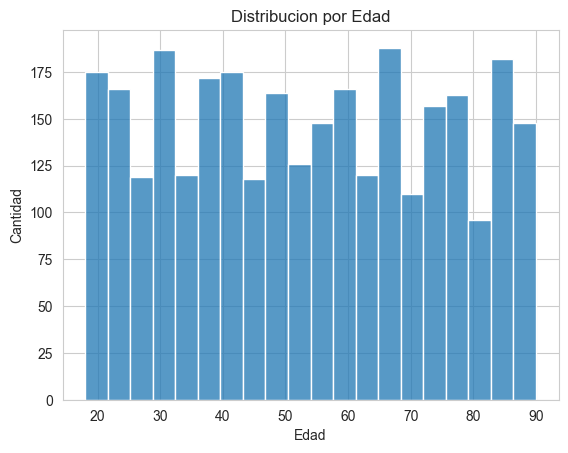

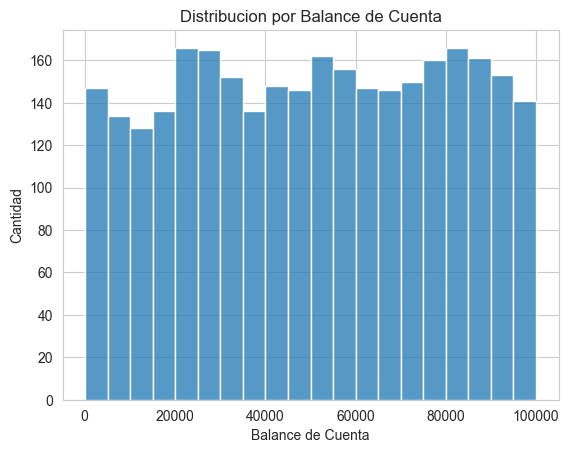

In [94]:
# Creamos el Histograma por Edad
sns.histplot(datos_segmentacion["Age"], bins=20) # Organizamos por 20 bines
plt.title("Distribucion por Edad")
plt.xlabel("Edad")
plt.ylabel("Cantidad")
plt.show()

# Creamos el Histograma por Balance de Cuenta
sns.histplot(datos_segmentacion["Account Balance"], bins=20)# Organizamos por 20 bines
plt.title("Distribucion por Balance de Cuenta")
plt.xlabel("Balance de Cuenta")
plt.ylabel("Cantidad")
plt.show()

Segun vemos en el grafico por Edad, tenemos lo siguiente:
- La cantidad de Clientes varia aproximadamente entre 75 y 175.
- Las edades que poseen mayor cantidad de individuos (apox. 175) estan alredodor de 20 a 30 años y 70 a 90.
- Figura un descenso importante en la cantidad (Entre 75 a 100) en las edades medias (40 a 60 años).
- Se poseen dos puntos de gran nro de individuos: uno en los jovenes (20 a 30) y otro en los mayores (70 a 90), con una planicie en edades medias.

Para los datos de distribucion por Balance de cuenta, entendemos lo siguiente:
- La cantidad de clientes por torre va de 130 a 160 aproximadamente.
- Los balances que mas figuran en los datos(aprox. 160) estan entre 0 a 20.000 y 80.000 a 100.000.
- Hay una cantidad de clientes uniforme entre los balances de 20.0000 a 80.0000, con las cantidades menores entre los 40.000 a 60.000 de balance.
- Los maximo y minimos se registran en los extremos (bajos y altos balances) con una planicie en el centro (Rango intermedio de balances).

## Segmentacion por Gender(Genero) y Account Type(Tipo de Cuenta)

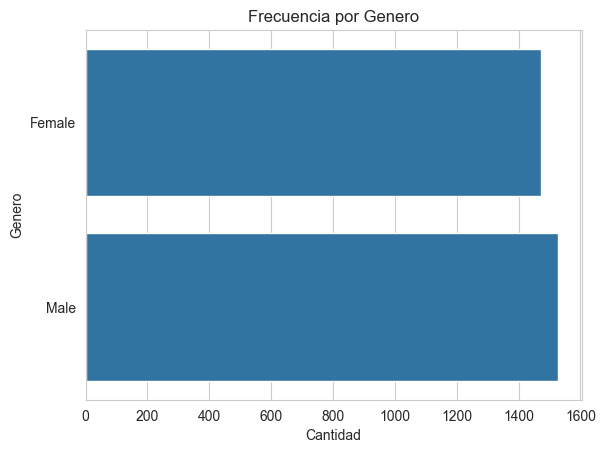

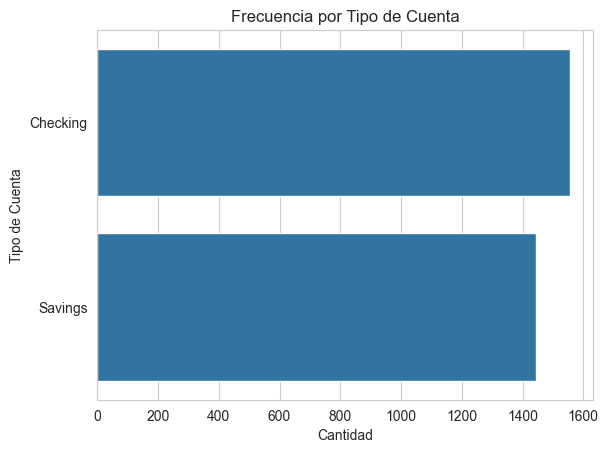

In [95]:
# Graficos de barras para Genero y Tipo de Cuenta
sns.countplot(datos_segmentacion["Gender"])
plt.title("Frecuencia por Genero")
plt.xlabel("Cantidad")
plt.ylabel("Genero")
plt.show()

# Grafico para Tipo de cuenta
sns.countplot(datos_segmentacion["Account Type"])
plt.title("Frecuencia por Tipo de Cuenta")
plt.xlabel("Cantidad")
plt.ylabel("Tipo de Cuenta")
plt.show()

Si analizamos el grafico de Frecuencia por Genero tenemos que, los clientes femeninos son menores a los masculinos. Mientras que si vemos la Frecuencia por Tipo de Cuenta, podemos ver que las cuentas de tipo Checking son mayores a las de Savings.

## Proceso de segmentacion por los datos numericos (Edad, Balance de Cuenta) y categoricos (Tipo de Cuenta, Genero)
Lo primero que realizare es saber cual es la cantidad de grupos a evaluar para el universo de datos que poseo, esto mediante el metodo del Grafico del Codo.

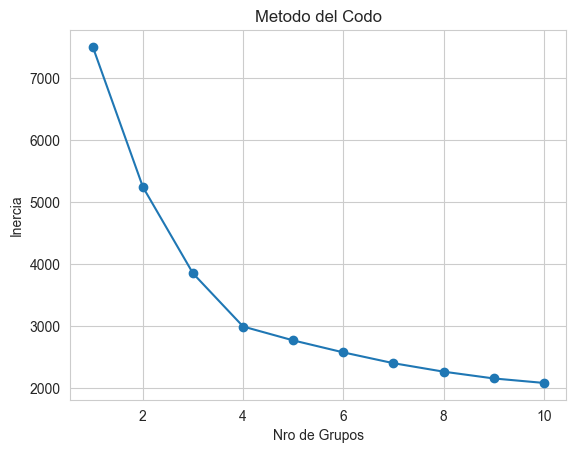

In [96]:


# Seleccionar columnas importantes
X = datos_segmentacion[["Age", "Account Balance", "Gender", "Account Type"]]

# Escalamos los datos numericos y definimos los categoricos
preproceso = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["Age", "Account Balance"]),
        ("cat", OneHotEncoder(drop="first"), ["Gender", "Account Type"])
    ]
)

X_procesados = preproceso.fit_transform(X)

# Calcular inercia
inercia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_procesados)
    inercia.append(kmeans.inertia_)

# Obtenemos el grafico de Codo
plt.plot(range(1,11), inercia, marker="o")
plt.xlabel("Nro de Grupos")
plt.ylabel("Inercia")
plt.title("Metodo del Codo")
plt.show()

Segun vemos, el retorno del metodo del Grafico de Codo nos dice que el nro ideal( Donde ya no disminuye tanto) de grupos es de 3 a 4 grupos. Para este caso usaremos 4 grupos.

## Visualizacion de grupos
A continuacion analizaremos el resultados de los diferentes grupos segun Edad y Balance de Cuentas

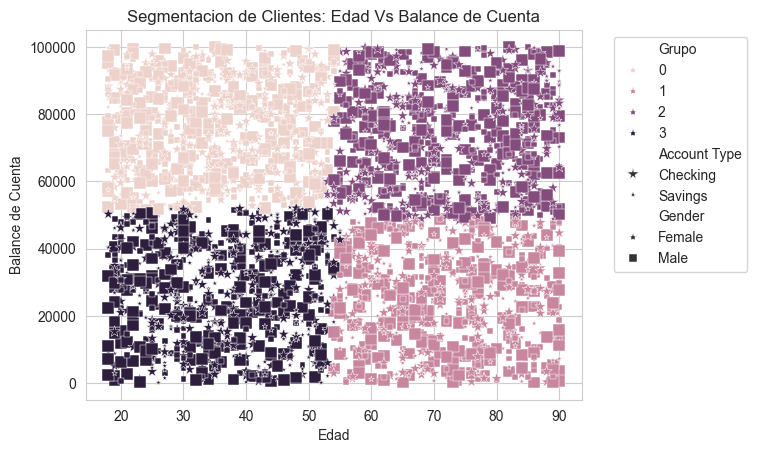

In [97]:
# Aplicar la cantidad de grupos
kmeans = KMeans(n_clusters=4, random_state=42)
datos_segmentacion["Grupo"] = kmeans.fit_predict(X_procesados)

# Usamos un grafico de dispersion separado en los grupos por colores
sns.scatterplot(x='Age', y='Account Balance', hue='Grupo', style='Gender', markers={'Female':'*', 'Male':'s'}, size='Account Type', data=datos_segmentacion)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Segmentacion de Clientes: Edad Vs Balance de Cuenta')
plt.ylabel("Balance de Cuenta")
plt.xlabel("Edad")
plt.show()

Segun se puede ver los grupos se dividen en lo siguiente:
- Grupo 1(0 en grafico): Grupo de edades jovenes adultos(entre 18 a 53 aprox) con balances en cuenta entre 55.000 a 100.000.
- Grupo 2(1 en grafico): Grupo de edades adultos mayores(entre 54 a 90 aprox) con balances entre 0 a 54.000.
- Grupo 3(2 en grafico): Grupo de edades adultos mayores(entre 54 a 90 aprox) con balances entre 55.000 a 100.000.
- Grupo 4(3 en grafico): Grupo de edades jovenes adultos(entre 18 a 53 aprox) con balances en cuenta entre 0 a 54.000.

Se entiende que segun el tamaño del simbolo, es la cantidad de tipos de cuentas que se encuentran en el mismo punto. Ademas de que los datos femeninos son Estrellas y los Cuadrados son Hombres.

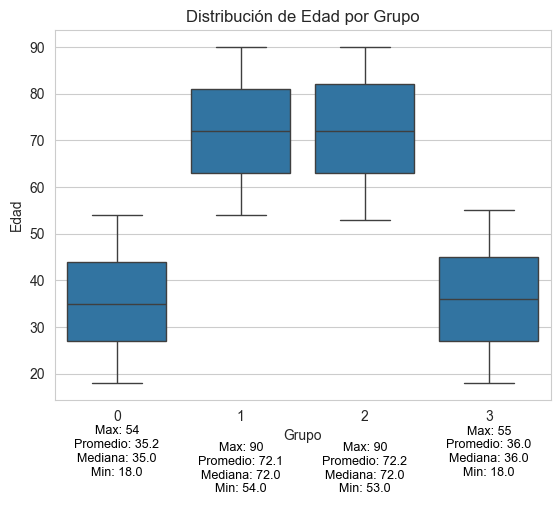

In [98]:
# Para ver de mejor manera los datos por grupo haremos un grafico de cajas
ax = sns.boxplot(x='Grupo', y='Age', data=datos_segmentacion)

# Añadir titulos y etiquetas de ejes
plt.title("Distribución de Edad por Grupo")
plt.ylabel('Edad')

#Calculamos las estadisticas por grupo
stats = datos_segmentacion.groupby('Grupo')['Age'].agg(['count', 'mean', 'median', 'min', 'max'])

# Añadir las anotaciones en el gráfico
for i, grupo in enumerate(stats.index):
    y = stats.loc[grupo, 'max']  # posición vertical para la etiqueta (por ejemplo el máximo)
    text = (f"Max: {stats.loc[grupo, 'max']}\n"
            f"Promedio: {stats.loc[grupo, 'mean']:.1f}\n"
            f"Mediana: {stats.loc[grupo, 'median']:.1f}\n"
            f"Min: {stats.loc[grupo, 'min']:.1f}\n")
    ax.text(i, y - (y+(y * 0.1)), text, ha='center', va='bottom', fontsize=9, color='black')

plt.show()

Como podemos ver los grupos 1 y 2 poseen las edades mas altas, con promedios de alrededor 70 a 72 años y un rango amplio hasta los 90 años. Mientras que los grupos 0 y 3 poseen edades mas bajas con promedios de 35 a 36 y con maximos que llegan a 54-55 años.

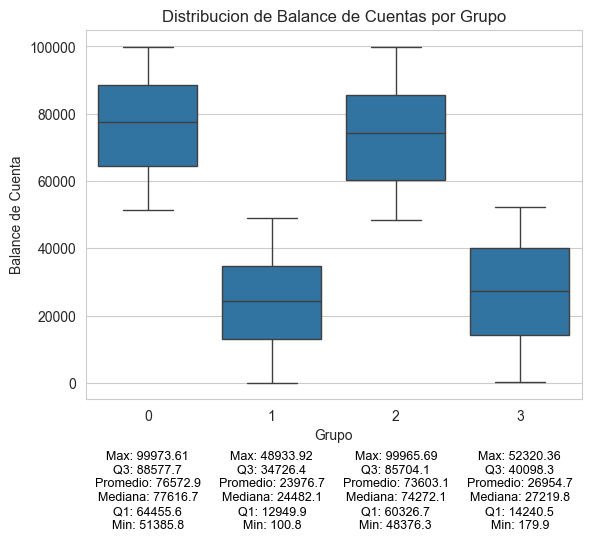

In [99]:
# Vereficamos los datos de balance por grupo
ax = sns.boxplot(x='Grupo', y='Account Balance', data=datos_segmentacion)

#Calculo de datos por grupos
stats = datos_segmentacion.groupby('Grupo')['Account Balance']\
    .agg(['count', 'mean', 'median', 'min', 'max',
          lambda x: x.quantile(0.25),
          lambda x: x.quantile(0.75),]
    ).rename(columns={"<lambda_0>":"Q1", "<lambda_1>":"Q3"})

# Titulos y etiquetas de ejes
plt.title("Distribucion de Balance de Cuentas por Grupo")
plt.ylabel("Balance de Cuenta")

# Mostrar datos por Grupo
for i, grupo in enumerate(stats.index):
    y = stats.loc[grupo, 'min']  # posición vertical para la etiqueta (por ejemplo el máximo)
    text = (f"Max: {stats.loc[grupo, 'max']}\n"
            f"Q3: {stats.loc[grupo, 'Q3']:.1f}\n"
            f"Promedio: {stats.loc[grupo, 'mean']:.1f}\n"
            f"Mediana: {stats.loc[grupo, 'median']:.1f}\n"
            f"Q1: {stats.loc[grupo, 'Q1']:.1f}\n"
            f"Min: {stats.loc[grupo, 'min']:.1f}\n")
    ax.text(i, 0 - (20000), text, ha='center', va='top', fontsize=9, color='black')

plt.show()

## ¿Se pueden identificar grupos de clientes (segmentación) con características similares?

**Sí**, **se pueden identificar grupos de clientes con características similares** mediante una segmentación clara basada en el **Balance de Cuenta**. El análisis de los grupos revela diferencias estadísticamente significativas en los niveles de saldo, permitiendo clasificar a los clientes en **cuatro segmentos bien definidos**:



## Resumen de Segmentación

| Grupo | Nivel de Balance     | Promedio   | Mediana   | IQR (Dispersión) | Perfil                          |
|-------|----------------------|------------|-----------|------------------|---------------------------------|
| **0** | **Alto (Premium)**   | 76,572.9   | 77,616.7  | 24,122.1         | Clientes de mayor patrimonio    |
| **2** | Alto (Premium)       | 73,603.1   | 74,272.1  | 25,377.4         | Similar a grupo 0, 2ª mayor dispersión |
| **3** | Intermedio           | 26,954.7   | 27,219.8  | 25,857.8         | Mayor dispersión, potencial de crecimiento |
| **1** | **Bajo**             | 23,976.7   | 24,486.1  | 21,776.5         | Mínimo 100.8, mayor riesgo de abandono |



## Conclusión: Sí, es posible segmentar

- Los grupos **0 y 2** concentran a los clientes **premium** (balances >60k), con promedios muy superiores y dispersiones moderadas.  
- El **grupo 3** actúa como **segmento intermedio** con mayor variabilidad (IQR más alto), ideal para estrategias de ascenso.  
- El **grupo 1** agrupa a los clientes de **bajo saldo**, con riesgo de inactividad.



## Recomendaciones Estratégicas por Segmento

- **Grupos 0 y 2 (Premium)**  
  → Fidelización, productos de inversión, crédito preferencial, gestión patrimonial.

- **Grupo 3 (Intermedio)**  
  → Educación financiera, upselling, cuentas de ahorro con beneficios, metas de crecimiento.

- **Grupo 1 (Bajo)**  
  → Microcréditos, reactivación de cuentas dormidas, productos de entrada (cuentas básicas sin costo).



> **Respuesta final:**  
> **Sí, se pueden identificar y segmentar grupos de clientes con características similares en función del Balance de Cuenta, permitiendo estrategias personalizadas por perfil de cliente.**

# ¿Qué perfiles de clientes tienen los saldos más altos?
Procedemos a agregar dato de antiguedad y crear rangos de edad. Para luego generar las agrupaciones correspondientes y obtener datos por agrupacion.

In [100]:
saldos_altos = datos_modif.copy()

# Obtener edad de los clientes
hoy = pd.Timestamp.today()
saldos_altos["Antiguedad"] = ((hoy - saldos_altos["Registration Date"]).dt.days / 365.25).round(1)

# Creamos rangos de edad
rangos = [18, 30, 40, 50, 60, 70, 80, 90]
etiq_rangos = ["18-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90"]
saldos_altos["Rango_edad"] = pd.cut(saldos_altos["Age"], bins=rangos, labels=etiq_rangos, include_lowest=True)


Comenzamos a mostrar los datos por agrupacion

In [101]:
# Saldos altos por tipo de cuenta
tipoCuenta_saldo = saldos_altos.groupby("Account Type", observed=False)["Account Balance"].agg(
    Promedio = 'mean',
    Mediana = 'median',
    Clientes = 'count',
    Total = 'sum'
).round(2).sort_values('Promedio', ascending=False)

print("SALDO PROMEDIO POR TIPO DE CUENTA")
print(tipoCuenta_saldo)

# Saldos altos por Rango de edad
rangoEdad_saldo = saldos_altos.groupby("Rango_edad", observed=False)["Account Balance"].agg(
    Promedio = 'mean',
    Mediana = 'median',
    Clientes = 'count',
    Total = 'sum'
).round(2).sort_values('Promedio', ascending=False)

print(f"="*100)
print("SALDO PROMEDIO POR RANGO DE EDAD")
print(rangoEdad_saldo)

# Saldos altos por Genero
genero_saldo = saldos_altos.groupby("Gender", observed=False)["Account Balance"].agg(
    Promedio = 'mean',
    Mediana = 'median',
    Clientes = 'count',
    Total = 'sum'
).round(2).sort_values('Promedio', ascending=False)

print(f"="*100)
print("SALDO PROMEDIO POR GENERO")
print(genero_saldo)

# Saldos altos por antiguedad
saldos_altos["Antiguedad_categ"] = pd.cut(
    saldos_altos["Antiguedad"], bins= [ 1, 3, 5, 6 ],
    labels=["1-3 años", ">3-5 años", ">5-6 años"]
)

antiguedad_saldo = saldos_altos.groupby("Antiguedad_categ", observed=False)["Account Balance"].agg(
    Promedio = 'mean',
    Mediana = 'median',
    Clientes = 'count',
    Total = 'sum'
).round(2).sort_values('Promedio', ascending=False)

print(f"="*100)
print("SALDO PROMEDIO POR ANTIGUEDAD")
print(antiguedad_saldo.head())

# Saldos altos por Tipo y Edad
rangoEdad_TipoCuenta_saldo = saldos_altos.groupby(["Account Type", "Rango_edad"], observed=False)["Account Balance"].agg(
    Promedio = 'mean',
    Mediana = 'median',
    Clientes = 'count',
    Total = 'sum'
).round(2).sort_values('Promedio', ascending=False)

print(f"="*100)
print("SALDO PROMEDIO POR EDAD Y TIPO CUENTA")
print(rangoEdad_TipoCuenta_saldo.head())


SALDO PROMEDIO POR TIPO DE CUENTA
              Promedio   Mediana  Clientes        Total
Account Type                                           
Checking      51192.64  51855.14      1555  79604560.74
Savings       50377.88  50483.56      1445  72796036.52
SALDO PROMEDIO POR RANGO DE EDAD
            Promedio   Mediana  Clientes        Total
Rango_edad                                           
31-40       52923.53  57263.18       420  22227884.56
81-90       51857.68  52456.38       394  20431924.88
41-50       51211.70  50477.56       417  21355277.05
18-30       50749.69  50285.70       559  28369074.02
51-60       50276.67  50841.64       399  20060392.31
61-70       49853.78  51429.52       430  21437123.26
71-80       48606.09  48376.30       381  18518921.18
SALDO PROMEDIO POR GENERO
        Promedio   Mediana  Clientes        Total
Gender                                           
Female  50936.45  51213.78      1473  75029383.60
Male    50668.77  51479.32      1527  77371213.

## Graficos de Saldos Altos por Agrupaciones

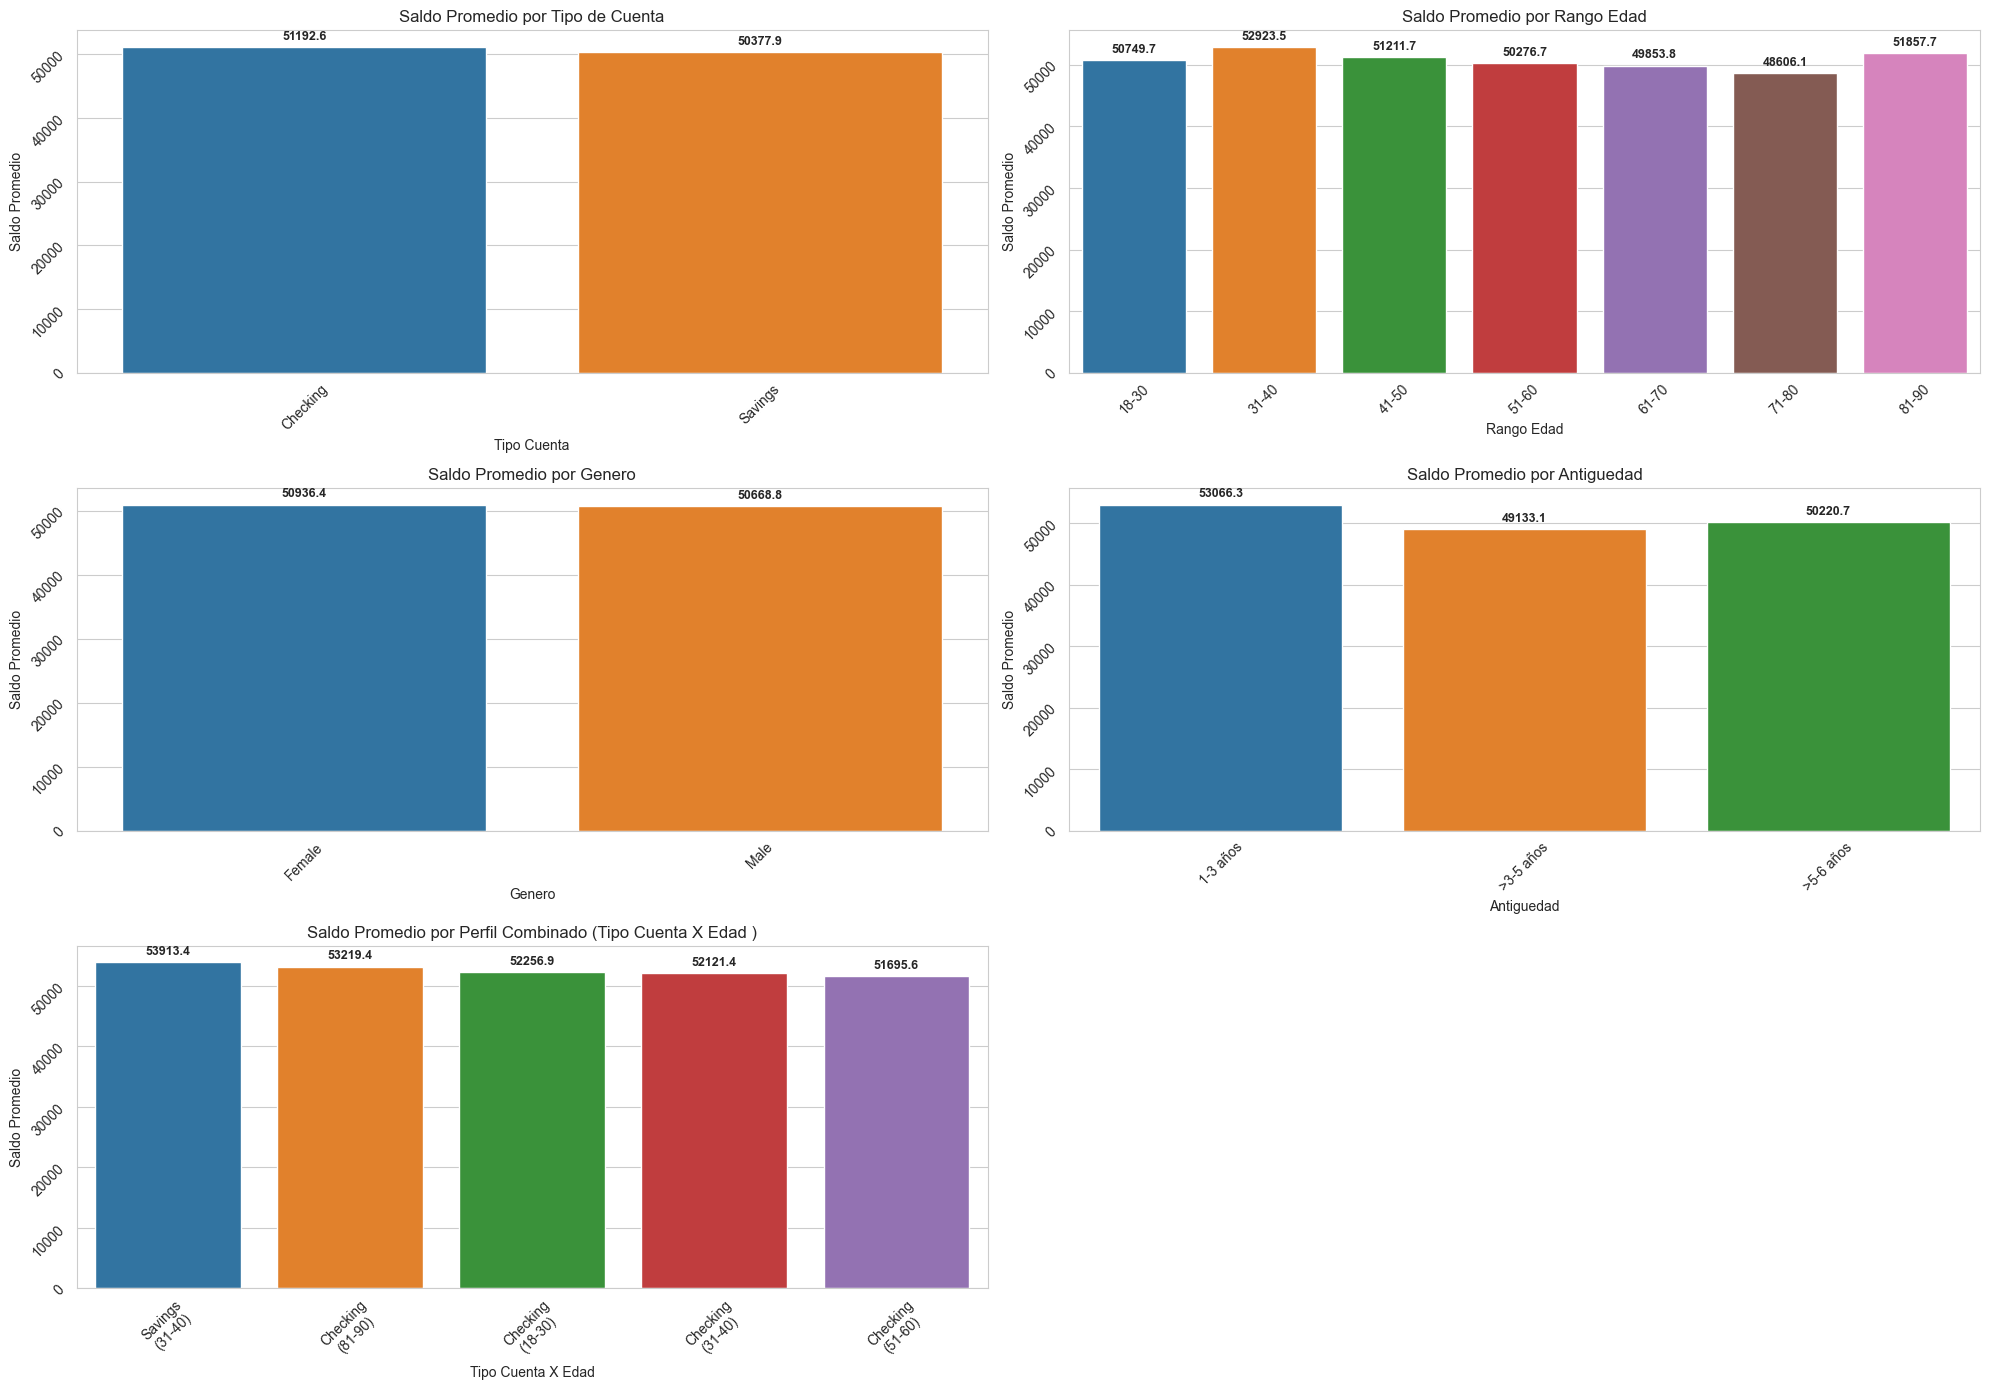

In [102]:
# Grafico 1: Saldo por tipo de cuenta

fig, axes = plt.subplots(3, 2, figsize=(20, 14)) # 3 filas, 2 columnas

ax_tipoCuenta_saldo = sns.barplot(data=tipoCuenta_saldo.reset_index(), x="Account Type", y="Promedio", hue="Account Type", ax=axes[0,0])
axes[0,0].set_title("Saldo Promedio por Tipo de Cuenta")
axes[0,0].set_ylabel("Saldo Promedio")
axes[0,0].set_xlabel("Tipo Cuenta")
axes[0,0].tick_params(rotation=45)

for contenedor in ax_tipoCuenta_saldo.containers:
     ax_tipoCuenta_saldo.bar_label(contenedor, label_type="edge", fontsize=9, fontweight='bold', padding=3)

# Grafico 2: Saldo por Edad
ax_rangoEdad_saldo = sns.barplot(x=rangoEdad_saldo.index, y=rangoEdad_saldo["Promedio"], hue=rangoEdad_saldo.index, ax=axes[0,1])
axes[0,1].set_title("Saldo Promedio por Rango Edad")
axes[0,1].set_ylabel("Saldo Promedio")
axes[0,1].set_xlabel("Rango Edad")
axes[0,1].tick_params(rotation=45)

for contenedor in ax_rangoEdad_saldo.containers:
     ax_rangoEdad_saldo.bar_label(contenedor, label_type="edge", fontsize=9, fontweight='bold', padding=3)


# Grafico 3: Saldo por Genero
ax_genero_saldo = sns.barplot(x=genero_saldo.index, y=genero_saldo["Promedio"], hue=genero_saldo.index, ax=axes[1,0])
axes[1,0].set_title("Saldo Promedio por Genero")
axes[1,0].set_ylabel("Saldo Promedio")
axes[1,0].set_xlabel("Genero")
axes[1,0].tick_params(rotation=45)

for contenedor in ax_genero_saldo.containers:
     ax_genero_saldo.bar_label(contenedor, label_type="edge", fontsize=9, fontweight='bold', padding=3)

# Grafico 4: Saldo por Antiguedad
ax_antiguedad_saldo = sns.barplot(x=antiguedad_saldo.index, y=antiguedad_saldo["Promedio"], hue=antiguedad_saldo.index, ax=axes[1,1])
axes[1,1].set_title("Saldo Promedio por Antiguedad")
axes[1,1].set_ylabel("Saldo Promedio")
axes[1,1].set_xlabel("Antiguedad")
axes[1,1].tick_params(rotation=45)

for contenedor in ax_antiguedad_saldo.containers:
     ax_antiguedad_saldo.bar_label(contenedor, label_type="edge", fontsize=9, fontweight='bold', padding=3)

# Grafico 5: Top 5 Perfiles combinados
top5 = rangoEdad_TipoCuenta_saldo.head(5)
top5.index = top5.index.map(lambda x: f"{x[0]}\n({x[1]})")
ax_top5_combinado_saldo = sns.barplot(x=top5.index, y=top5["Promedio"], hue=top5.index, ax=axes[2,0])
axes[2,0].set_title("Saldo Promedio por Perfil Combinado (Tipo Cuenta X Edad )")
axes[2,0].set_ylabel("Saldo Promedio")
axes[2,0].set_xlabel("Tipo Cuenta X Edad")
axes[2,0].tick_params(rotation=45)

for contenedor in ax_top5_combinado_saldo.containers:
     ax_top5_combinado_saldo.bar_label(contenedor, label_type="edge", fontsize=9, fontweight='bold', padding=3)

fig.delaxes(axes[2,1])

plt.tight_layout()
plt.show()

Como podemos ver los graficos retornan lo siguiente:
- El tipo de cuenta con el promedio de saldo mas alto es: Cheking con $51.192,6
- El rango de edad con el promedio de saldo mas altos son: 31-40 con $52.923,5
- El Genero con el promedio mas alto es el: Femenino con $50.936,4
- La antiguedad con el promedio mas alto de saldo es: 1 a 3 años con $52.909,9
- El perfil combinado (Tipo Cuenta X Edad) con el promedio de saldo mas alto es: Savings con $53.913,4

lo que nos dice que:
- Los clientes con mayor saldo son mujeres entre 31 a 40 años con cuentas de ahorro que tienen entre 1 a 3 años de antiguedad.

por lo que:
- El perfil con mayor valor para el banco no es el cliente que mas tiempo lleva en el banco, ni tampoco asi, el mas joven, ni el con cuenta corriente. Si no, la mujer en plena etapa de tranbajo entre 31 a 40 años de edad quien posee una cuenta de ahorro desde hace 1 a 3 años de antiguedad.

Asi tenemos que:
- Nuestro cliente mas rentable es la mujer de 31 a 40 años de edad con cuenta de ahorro con antiguedad de 1 a 3 años.

Teniendo estos datos se puede promover la obtencion de clientas en el rango de edad, con el la idea de aportarle una forma de ahorro a mediano plazo, ofreciendole tasas preferenciales en los primeros 3 años. Pasado de 12 a 18 meses se le pueden otorgar programas de Cashback o tasas altas para cuando el cliente entre en la zona de saldo alto para asi retenerla en el tiempo.

# ¿Cuál es la proporción de clientes con cuentas de ahorro vs cuenta corriente?
Procederemos a mostrar la informacion de forma escrita y mediante graficos

In [103]:
# obtenemos la informacion
proporcion_tipoCuenta = datos_modif.copy()

# contamos los datos
conteo = proporcion_tipoCuenta["Account Type"].value_counts()
total_clientes = conteo.sum()

# proporciones
proporcion = (conteo / total_clientes * 100).round(2)

print("DISTRIBUCIÓN DE TIPOS DE CUENTA")
print("="*50)
print(f"Total clientes analizados: {total_clientes}")
print(f"Savings (Ahorro):  {conteo.get('Savings', 0)} clientes → {proporcion.get('Savings', 0)}%")
print(f"Checking (Corriente): {conteo.get('Checking', 0)} clientes → {proporcion.get('Checking', 0)}%")


DISTRIBUCIÓN DE TIPOS DE CUENTA
Total clientes analizados: 3000
Savings (Ahorro):  1445 clientes → 48.17%
Checking (Corriente): 1555 clientes → 51.83%


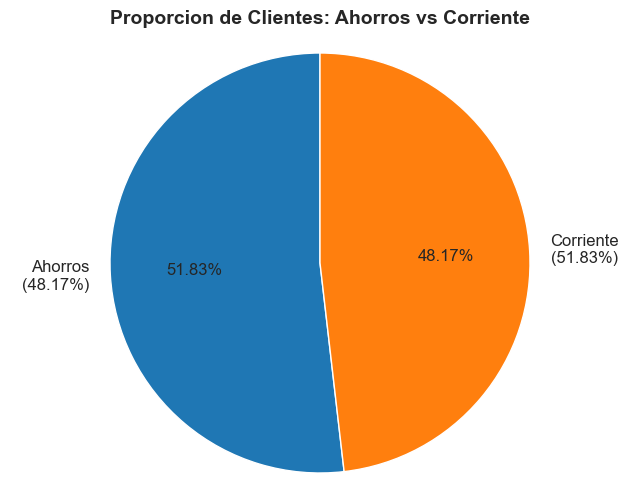

In [104]:
# Grafico de torta
plt.figure(figsize=(8,6))

plt.pie( 
    conteo,
    labels=[ 
            f'Ahorros\n({proporcion["Savings"]:.2f}%)', 
            f'Corriente\n({proporcion["Checking"]:.2f}%)' ],
    autopct='%1.2f%%',
    startangle=90,
    textprops={'fontsize': 12}
)

plt.title("Proporcion de Clientes: Ahorros vs Corriente", fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

Revisando los datos, obtenemos que:
- Los clientes estan practicamente divididos de forma equilibrada entre cuentas de ahorro (48.71%) y cuentas corriente (51.83%), dejando asi a las cuentas corrientes con una ventaja de 3,7% (110 de diferencia).

Por lo que:
- Es factible ofrecer cuentas corrientes con ahorro en formato automatico, incrementando asi la cantidad de clientes con cuentas de ahorros sin afectar a los con cuentas corriente.
- Ademas de entregar informacion segun tipo de cuenta, para mejoras de retencion y up-sell personalizado.

# ¿Se puede predecir el tipo de cuenta de un cliente según sus datos demográficos?
Analizaremos si es posible predecir el tipo de cuenta de un cliente segun sus datos demograficos

In [105]:
warnings.filterwarnings('ignore')

# Obtenemos las columnas relevantes para el caso
columnas = ["Age", "Gender", "Address", "Account Type"]
datosDemograf_predictivos = datos_modif[columnas].copy()

# Extraemos informacion util de la direccion
def identificar_tipo_direccion(direccion):
    direccion_upper = str(direccion).upper()
    # Verificar si es dirección militar
    if re.search(r'\b(APO|FPO|DPO)\b', direccion_upper):
        return "militar"
    else: return "civil"

# Datos Civiles
def extraer_ciudad_estado(direccion):
    # Expresión regular mejorada para captar más variaciones
    patron = r'(?P<calle>.*)\s+(?P<ciudad>[A-Za-z\s]+),\s*(?P<estado>[A-Z]{2})\s+(?P<codigo_postal>\d{5}(-\d{4})?)'
    match = re.search(patron, direccion)
    if match:
        ciudad = match.group('ciudad').strip()
        estado = match.group('estado').strip()
        return ciudad, estado
    else:
        # Intentar con otro patrón más simple o manejar excepción
        patron_simple = r'([^,]+),\s*([A-Z]{2})\s*\d{5}'
        match_simple = re.search(patron_simple, direccion)
        if match_simple:
            ciudad = match_simple.group(1).strip()
            estado = match_simple.group(2).strip()
            return ciudad, estado
    return None, None

#Datos militares
APO_TO_REGION = {"AA": "Armed Forces Americas", "AE":"Armed Forces Europe", "AP":"Armed Forces Pacific"} 
def extraer_ciudad_estado_militar(direccion):
    direccion = str(direccion)
    if re.search(r'\b(APO|FPO|DPO)\b', direccion):
        match = re.search(r'(APO|FPO|DPO)\s*(AA|AE|AP)\s*\d', direccion)
        if match:
            codigo_region = match.group(2)
            return APO_TO_REGION[codigo_region], codigo_region
    return None, None

# obtiene datos segun direccion
def extraer_datos(direccion):
    tipo = identificar_tipo_direccion(direccion)
    if tipo == "militar":
        return extraer_ciudad_estado_militar(direccion)
    elif tipo == "civil":
        return extraer_ciudad_estado(direccion)
    else:
        return "civil"

# aplicacion de funcion de estado y ciudad 
datosDemograf_predictivos[["Estado", "Ciudad"]] = datosDemograf_predictivos["Address"].apply(
    lambda x : pd.Series( extraer_datos(x) )
)

# se categorizan las variables geograficas en numeros
le_estado = LabelEncoder()
le_ciudad = LabelEncoder()

datosDemograf_predictivos["Estado_encoded"] = le_estado.fit_transform(datosDemograf_predictivos["Estado"])
datosDemograf_predictivos["Ciudad_encoded"] = le_ciudad.fit_transform(datosDemograf_predictivos["Ciudad"])

# lo mismo para variables de tipo y genero
le_genero = LabelEncoder() 
le_tipoCuenta = LabelEncoder()

datosDemograf_predictivos["TipoCuenta_encoded"] = le_tipoCuenta.fit_transform(datosDemograf_predictivos["Account Type"])
datosDemograf_predictivos["Genero_encoded"] = le_genero.fit_transform(datosDemograf_predictivos["Gender"])

# definimos las variables para la prediccion 
X = datosDemograf_predictivos[["Age", "Genero_encoded", "Estado_encoded", "Ciudad_encoded"]]
y = datosDemograf_predictivos["TipoCuenta_encoded"]

# dividimos las pruebas y el entrenamiento

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# escalamos las variablles numericas
scaler = StandardScaler()
X_entrenamiento_escalado = scaler.fit_transform(X_entrenamiento)
X_prueba_escalado = scaler.fit_transform(X_prueba)

# entrenamos el modelo

modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_entrenamiento_escalado, y_entrenamiento )

# predecimos y evaluamos resultados
y_prediccion = modelo.predict(X_prueba_escalado)

print("Precisión:", accuracy_score(y_prueba, y_prediccion))
print("\nReporte de clasificación:")
target_names = le_tipoCuenta.classes_
print(classification_report(y_prueba, y_prediccion, target_names=target_names))

# importancia de variables
importancias = pd.DataFrame({
    'Variable' : X.columns,
    'Importancia': modelo.feature_importances_
}).sort_values('Importancia', ascending=True)

print("\nImportancia de variables:")
print(importancias)

Precisión: 0.47833333333333333

Reporte de clasificación:
              precision    recall  f1-score   support

    Checking       0.50      0.53      0.51       311
     Savings       0.45      0.42      0.44       289

    accuracy                           0.48       600
   macro avg       0.48      0.48      0.48       600
weighted avg       0.48      0.48      0.48       600


Importancia de variables:
         Variable  Importancia
1  Genero_encoded     0.036898
3  Ciudad_encoded     0.264826
0             Age     0.309663
2  Estado_encoded     0.388612


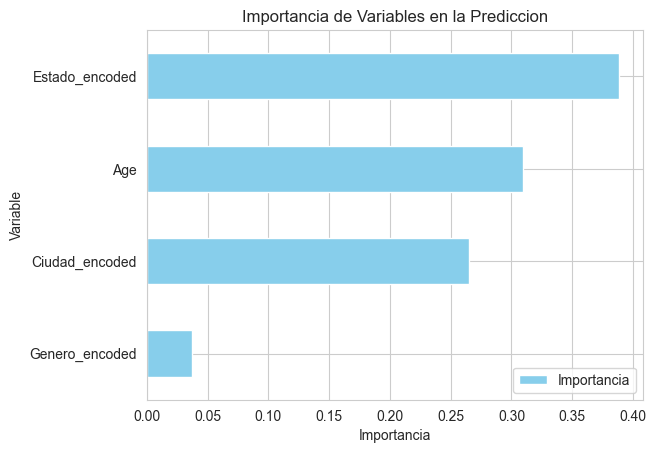

In [106]:
# Grafico
importancias.plot(kind='barh', x='Variable', y='Importancia', color='skyblue')
plt.title("Importancia de Variables en la Prediccion")
plt.xlabel("Importancia")
plt.show()

### **Respuesta a: ¿Se puede predecir el tipo de cuenta de un cliente según sus datos demográficos?**  
**No es posible predecir con fiabilidad el tipo de cuenta (`Checking` o `Savings`) utilizando únicamente las variables demográficas en los datos (`Age`, `Gender`, `City`, `State`).**

#### **Evidencia:**
1. **La precisión del modelo: 47.8%**  
   → **Inferior a adivinar al azar (50%)** en un problema de dos clases balanceadas.

2. **Las variables demográficas no tienen poder predictivo suficiente:**  
   - Aunque `Estado` (38.9%) y `Edad` (31.0%) son las más usadas por el modelo, **no logran separar las clases**.  
   - `Género` aporta solo **3.7%** de importancia → prácticamente no importa el genero al momento de predecir.  
   - `Ciudad` contribuye moderadamente (26.5%), pero no compensa la falta de peso en la prediccion.

3. **Faltan variables determinantes del comportamiento financiero:**  
   → Para predecir el tipo de cuenta se necesitan datos como: 
   - **Frecuencia de transacciones**  
   - **Ingresos o capacidad de ahorro**  
   - **Historial de productos contratados**

# ¿Se puede predecir si un cliente tendrá un saldo alto o bajo?
Analizaremos lo siguiente para verificar si podemos realizar la prediccion.

In [107]:
predicc_saldo = datos_modif.copy()

# usaremos el percentil 75 para el analisis
umbral = predicc_saldo["Account Balance"].median()
predicc_saldo["Saldo_alto"] = ( predicc_saldo["Account Balance"] > umbral ).astype(int)

print(f"Umbral de saldo alto: {umbral}")
print(predicc_saldo['Saldo_alto'].value_counts())

Umbral de saldo alto: 51388.25
Saldo_alto
0    1500
1    1500
Name: count, dtype: int64


El analisis a las variables es el siguiente

Age -> util -> Nrica
Gender -> util -> se debe modificar
Account Type -> util -> se debe modificar
Registration Date -> util -> extraer la antiguedad
Account Balance -> dato a predecir -> No usar
Customer ID, Name, Address, Email, Phone -> no util -> eliminar de los datos

por lo que utilizaremos los datos Age, Gender, Account Type y Registration Date.


Presicion: 0.5016666666666667

Reporte de Clasificacion:
              precision    recall  f1-score   support

  Saldo Bajo       0.50      0.54      0.52       300
  Saldo Alto       0.50      0.47      0.48       300

    accuracy                           0.50       600
   macro avg       0.50      0.50      0.50       600
weighted avg       0.50      0.50      0.50       600

       Variable  Importancia
3    Antiguedad     0.594914
0           Age     0.362056
1        Gender     0.021684
2  Account Type     0.021347


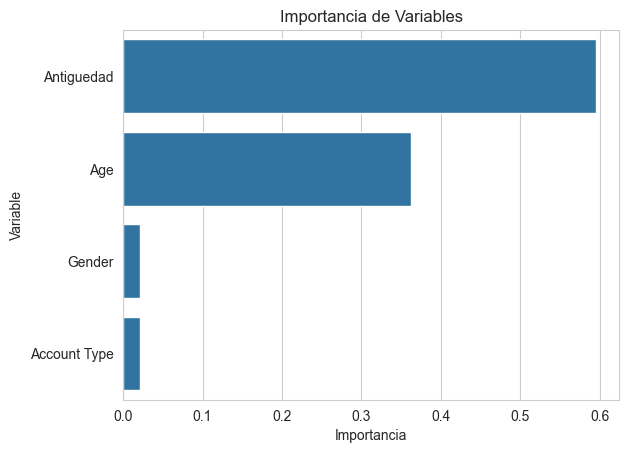

In [108]:
# eliminamos las columnas que no se utilizaran
predicc_saldo = predicc_saldo.drop(['Customer ID', 'Name', 'Address', 'Email', 'Phone Number', 'Account Balance'], axis=1)

# obtenemos la antiguedad de la fecha de registro
hoy = pd.to_datetime('today')
predicc_saldo["Antiguedad"] = (hoy - predicc_saldo["Registration Date"]).dt.days
predicc_saldo = predicc_saldo.drop("Registration Date", axis=1)

# codificamos datos categoricos
le_genero = LabelEncoder()
le_tipoCuenta = LabelEncoder()

predicc_saldo["Gender"] = le_genero.fit_transform(predicc_saldo["Gender"])
predicc_saldo["Account Type"] = le_tipoCuenta.fit_transform(predicc_saldo["Account Type"])

# Dividimos y escalamos datos
X = predicc_saldo.drop("Saldo_alto", axis=1)
y = predicc_saldo["Saldo_alto"]

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar variables nricas
escalador = StandardScaler()
X_entrenamiento[["Age", "Antiguedad"]] = escalador.fit_transform(X_entrenamiento[["Age", "Antiguedad"]])
X_prueba[["Age", "Antiguedad"]] = escalador.transform(X_prueba[["Age", "Antiguedad"]])

# entrenamos el modelo
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_entrenamiento, y_entrenamiento)

# predicciones
y_prediccion = modelo.predict(X_prueba)

print("Presicion:", accuracy_score(y_prueba, y_prediccion))
print("\nReporte de Clasificacion:")
print(classification_report(y_prueba, y_prediccion, target_names=['Saldo Bajo', 'Saldo Alto']))

# importancias de variables
importancias = pd.DataFrame({
    'Variable' : X.columns,
    'Importancia' : modelo.feature_importances_
}).sort_values('Importancia', ascending=False)

print( importancias )

# Grafico
sns.barplot(x="Importancia", y='Variable', data=importancias)
plt.title("Importancia de Variables")
plt.show()

### **Respuesta a: ¿Se puede predecir si un cliente tendrá un saldo alto o bajo?**
**No es posible predecir con fiabilidad  si un cliente tendrá un saldo alto o bajo utilizando únicamente las variables disponibles (`Age`, `Gender`, `Account Type`, `Registration Date`).**

#### **Evidencia:**
1. **La precision del modelo: ~50%**
→ Equivalente a adivinar al azar(Aun usando la mediana como umbral).

2. **Las variables usadas no tienen relación significativa con el saldo:**  
   - Correlación máxima observada: `Antiguedad` (~0.25), `Age` (~0.15).  
   - `Gender` y `Account Type` aportan < 5% de importancia.

3. **Faltan variables financieras críticas:**  
   → Para predecir el saldo es necesario datos como:  
   - **Transacciones (frecuencia, monto)**  
   - **Ingresos o nómina**  
   - **Productos contratados (inversiones, créditos, seguros)**  
   - **Patrón de uso (ahorro vs. gasto)**

#### **Conclusión:**
> **Con los datos actuales, no es posible construir un modelo predictivo útil para este caso.** 

# ¿Qué factores influyen más en el saldo de cuenta de los clientes?
Analisaremos cuales factores son relevantes a la hora de predecir si influyen en el saldo.

Correlacion con Saldo:
Account Balance        1.000000
Gender                -0.004674
Account Type          -0.014221
Age                   -0.019693
dias_desde_registro   -0.040491
Name: Account Balance, dtype: float64


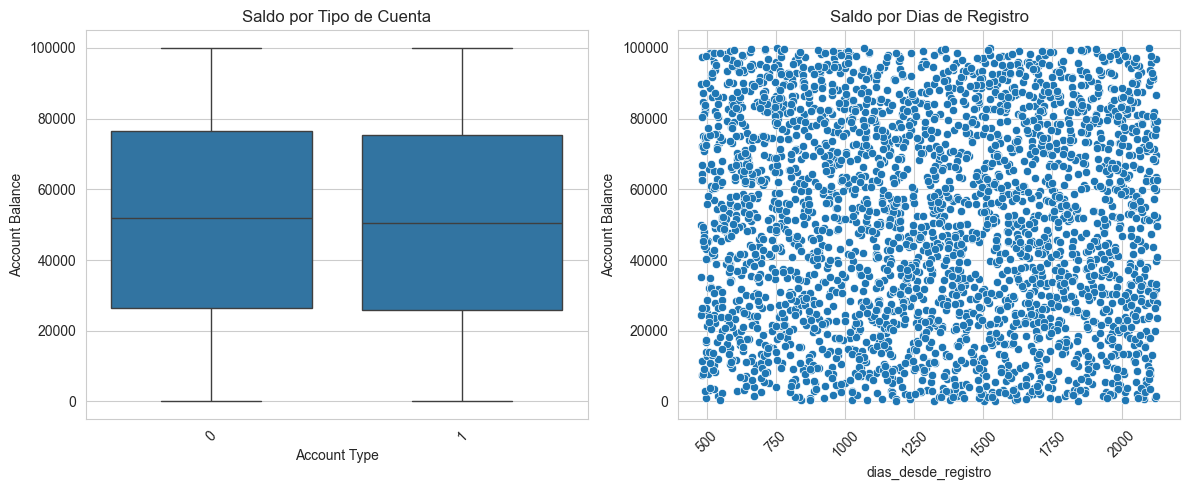

In [109]:
# Copiamos los datos para no generar problemas
predic_saldo = datos_modif.copy()

# Generamos datos a partir de la informacion
# Antiguedad
predic_saldo["dias_desde_registro"] = (pd.Timestamp.today() - predic_saldo["Registration Date"]).dt.days

# Se eliminan datos irrelevantes al caso
predic_saldo = predic_saldo.drop(["Customer ID", "Name", "Address", "Email", "Phone Number", "Registration Date"], axis=1)

# codificacion de variables categoricas
le_genero = LabelEncoder()
le_tipoCuenta = LabelEncoder()

predic_saldo["Gender"] = le_genero.fit_transform(predic_saldo["Gender"])
predic_saldo["Account Type"] = le_tipoCuenta.fit_transform(predic_saldo["Account Type"])

# Vemos la correlacion con respecto al saldo
correlacion = predic_saldo.corr()["Account Balance"].sort_values(ascending=False)
print("Correlacion con Saldo:")
print(correlacion)

# Despliegue del grafico
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x="Account Type", y="Account Balance",data=predic_saldo)
plt.xticks(rotation=45)
plt.title("Saldo por Tipo de Cuenta")

plt.subplot(1, 2, 2)
sns.scatterplot(x="dias_desde_registro", y="Account Balance", data=predic_saldo)
plt.xticks(rotation=45)
plt.title("Saldo por Dias de Registro")

plt.tight_layout()
plt.show()


Importancia de variables (Random Forest):
               Feature  Importance
3  dias_desde_registro    0.551378
0                  Age    0.343095
2         Account Type    0.053444
1               Gender    0.052083


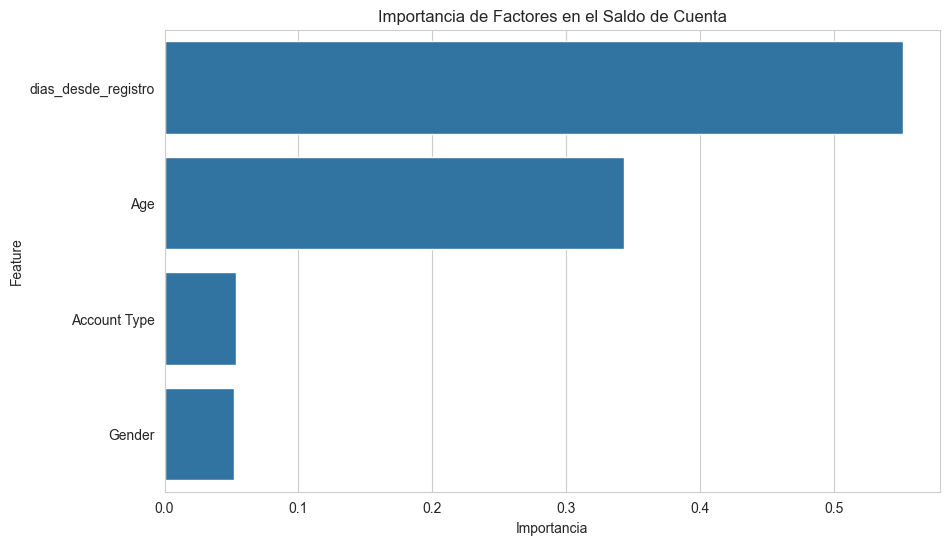


=== CONCLUSIÓN ===
Los factores que más influyen en el saldo de cuenta son:
- Antigüedad del cliente (días desde registro): 0.551
- Edad del cliente: 0.343
- Tipo de cuenta: 0.053
- Género: 0.052


In [110]:
# Realizamos la prediccion

#Variables predictoras 
X = predic_saldo.drop('Account Balance', axis=1)
y = predic_saldo["Account Balance"]

# Dividimos datos
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_entrenamiento, y_entrenamiento)

# Importancias
importancias = rf.feature_importances_
features_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': features_names,
    'Importance': importancias
}).sort_values('Importance', ascending=False)

print("\nImportancia de variables (Random Forest):")
print(feature_importance_df)

# Gráfico de importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importancia de Factores en el Saldo de Cuenta')
plt.xlabel('Importancia')
plt.show()

print("\n=== CONCLUSIÓN ===")
print("Los factores que más influyen en el saldo de cuenta son:")
for i, row in feature_importance_df.iterrows():
    if row['Importance'] > 0.05:  # Umbral arbitrario
        if row['Feature'] == 'dias_desde_registro':
            print(f"- Antigüedad del cliente (días desde registro): {row['Importance']:.3f}")
        elif row['Feature'] == 'Account Type':
            print(f"- Tipo de cuenta: {row['Importance']:.3f}")
        elif row['Feature'] == 'Age':
            print(f"- Edad del cliente: {row['Importance']:.3f}")
        elif row['Feature'] == 'Gender':
            print(f"- Género: {row['Importance']:.3f}")

Segun los datos podemos decir:
Los factores que más influyen en el saldo de cuenta son:

1. **Antigüedad del cliente** → **55.1%** de importancia  
   Clientes con más tiempo en el banco acumulan significativamente más saldo.

2. **Edad del cliente** → **34.3%** de importancia  
   Clientes mayores tienden a tener saldos más altos (posiblemente por mayor capacidad de ahorro).

3. **Tipo de cuenta** → **5.3%**  
   Aunque relevante, el tipo de cuenta tiene un impacto medio.

4. **Género** → **5.2%**  
   Prácticamente irrelevante en la predicción del saldo.

Por lo que:
 - Un cliente con mas años puede tener un saldo 3 a 5 veces mayor.
 - Tambien se puede decir que los clientes de mas edad son el grupo con mayor valor.
 - El tipo de cuenta es importante, pero menos de lo esperado. Es decir que, toda cuenta bien manejada tiene potencial similar.

 Por lo que se puede ofrecer:
 - Programas de fidelidad, bonos por antiguedad, ya que tiene un 55% aproximado de impacto en el saldo.
 - Programas para mayores de 40-50 años ( Inversiones, Planes de retiro)
 - Ofrecer cuentas de inversion o nomina con beneficios, debido a la importancia subestimada del tipo de cuenta.